# prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from time import time
import warnings
warnings.filterwarnings("ignore") ##忽略警告

In [ ]:
data1m = pd.read_csv("/content/drive/My Drive/Datasets/accepts_data_1m.csv")

In [ ]:
data1m

,application_id,account_number,bad_ind,vehicle_year,vehicle_make,bankruptcy_ind,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,tot_rev_tr,tot_rev_debt,tot_rev_line,rev_util,fico_score,purch_price,msrp,down_pyt,loan_term,loan_amt,ltv,tot_income,veh_mileage,used_ind,weight
0,2314049,11613,1,1998.0,FORD,N,7.0,9.0,64.0,2.0,1.0,506.0,500.0,101,650.0,17200.00,17350.0,0.00,36,17200.00,99.0,6550.00,24000.0,1,1.00
1,63539,13449,0,2000.0,DAEWOO,N,0.0,21.0,240.0,11.0,7.0,34605.0,57241.0,60,649.0,19588.54,19788.0,683.54,60,19588.54,99.0,4666.67,22.0,0,4.75
2,7328510,14323,1,1998.0,PLYMOUTH,N,7.0,10.0,60.0,NaN,NaN,NaN,NaN,0,613.0,13595.00,11450.0,0.00,60,10500.00,92.0,2000.00,19600.0,1,1.00
3,8725187,15359,1,1997.0,FORD,N,3.0,10.0,35.0,5.0,4.0,4019.0,5946.0,68,603.0,12999.00,12100.0,3099.00,60,10800.00,118.0,1500.00,10000.0,1,1.00
4,4275127,15812,0,2000.0,TOYOTA,N,0.0,10.0,104.0,2.0,0.0,0.0,1800.0,0,764.0,26328.04,22024.0,0.00,60,26328.04,122.0,4144.00,14.0,0,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1111025,883183,1,1996.0,DODGE,N,6.0,20.0,112.0,3.0,1.0,167.0,491.0,34,605.0,12348.00,9600.0,1248.00,48,9500.00,109.0,1858.33,70000.0,1,1.00
999996,6633458,883371,0,1995.0,CADILLAC,N,2.0,11.0,312.0,1.0,0.0,0.0,7500.0,0,603.0,17358.44,16500.0,3200.00,54,14158.44,86.0,4250.00,48000.0,1,4.75
999997,5463519,884016,1,1994.0,NISSAN,N,0.0,4.0,17.0,3.0,2.0,591.0,981.0,60,641.0,7601.66,5850.0,1751.66,48,5850.00,129.0,1800.00,55872.0,1,1.00
999998,1966255,884932,0,2000.0,B50,N,1.0,22.0,182.0,9.0,4.0,13244.0,41500.0,32,677.0,38359.64,41995.0,5500.00,60,32899.64,79.0,12500.00,1.0,0,4.75


In [ ]:
sample_df = data1m.copy()
lst_cat = ["vehicle_year", "vehicle_make","bankruptcy_ind","used_ind"]   ## year as cat, multi value cat, and N / Y cat

In [ ]:
# treat tot_tr as having some -99xxxx values
sample_df.tot_tr[0:300] = -999901
sample_df.tot_tr[301:900] = -999902
sample_df.tot_tr[901:1000] = -999999
sample_df.tot_tr[1000:1800] = np.nan

# tot_rev_debt as having 1 -99xxxx value
sample_df.tot_rev_debt[00:300] = -999999
sample_df.tot_rev_debt[301:800] = np.nan

# insert some nan to vehicle make
sample_df.vehicle_make[301:800] = 'nan'

# treat used_ind as highly skewed data
sample_df.used_ind[0:950000] = 0
sample_df.used_ind[950000:990000] = 2

# treat tot_derog , and age_oldest_tr and the rest as normal continuous feature

sample_df

,application_id,account_number,bad_ind,vehicle_year,vehicle_make,bankruptcy_ind,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,tot_rev_tr,tot_rev_debt,tot_rev_line,rev_util,fico_score,purch_price,msrp,down_pyt,loan_term,loan_amt,ltv,tot_income,veh_mileage,used_ind,weight
0,2314049,11613,1,1998.0,FORD,N,7.0,-999901.0,64.0,2.0,1.0,-999999.0,500.0,101,650.0,17200.00,17350.0,0.00,36,17200.00,99.0,6550.00,24000.0,0,1.00
1,63539,13449,0,2000.0,DAEWOO,N,0.0,-999901.0,240.0,11.0,7.0,-999999.0,57241.0,60,649.0,19588.54,19788.0,683.54,60,19588.54,99.0,4666.67,22.0,0,4.75
2,7328510,14323,1,1998.0,PLYMOUTH,N,7.0,-999901.0,60.0,NaN,NaN,-999999.0,NaN,0,613.0,13595.00,11450.0,0.00,60,10500.00,92.0,2000.00,19600.0,0,1.00
3,8725187,15359,1,1997.0,FORD,N,3.0,-999901.0,35.0,5.0,4.0,-999999.0,5946.0,68,603.0,12999.00,12100.0,3099.00,60,10800.00,118.0,1500.00,10000.0,0,1.00
4,4275127,15812,0,2000.0,TOYOTA,N,0.0,-999901.0,104.0,2.0,0.0,-999999.0,1800.0,0,764.0,26328.04,22024.0,0.00,60,26328.04,122.0,4144.00,14.0,0,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1111025,883183,1,1996.0,DODGE,N,6.0,20.0,112.0,3.0,1.0,167.0,491.0,34,605.0,12348.00,9600.0,1248.00,48,9500.00,109.0,1858.33,70000.0,1,1.00
999996,6633458,883371,0,1995.0,CADILLAC,N,2.0,11.0,312.0,1.0,0.0,0.0,7500.0,0,603.0,17358.44,16500.0,3200.00,54,14158.44,86.0,4250.00,48000.0,1,4.75
999997,5463519,884016,1,1994.0,NISSAN,N,0.0,4.0,17.0,3.0,2.0,591.0,981.0,60,641.0,7601.66,5850.0,1751.66,48,5850.00,129.0,1800.00,55872.0,1,1.00
999998,1966255,884932,0,2000.0,B50,N,1.0,22.0,182.0,9.0,4.0,13244.0,41500.0,32,677.0,38359.64,41995.0,5500.00,60,32899.64,79.0,12500.00,1.0,0,4.75


In [ ]:
dict_na = {"vehicle_year":["1998.0"], "vehicle_make":["FORD","B50"]}

# Class

In [ ]:
## New OO Helper with cleaned code

import os
import pandas as pd
import numpy as np
from time import time as now
from scipy.stats import chi2, chisquare
import math
from sklearn.base import TransformerMixin


class VarBinHelper(TransformerMixin):

    def __init__(self, **kwargs):
        ## initialise the object with name of label column, min_sample, min_bin_num
        self.min_sample = kwargs.get('min_sample', 0.02)
        self.min_bin = kwargs.get('min_bin', 2)
        self.max_bin = kwargs.get('max_bin', 10)
        self.chimerge_threshold = kwargs.get("chimerge_threshold", chi2.ppf(0.95, 1))
        self.label = kwargs.get('label', None)
        self._fit = False
        self.missing_values_found = {} ## will be a dict
        
        ## to make the class interface same as other versions from the team
        self.categorical_features = None ## updated in fit() 
        self.numerical_features = None ## updated in fit() 
        self.woe_encoder = None  ## model
        self.dict_binlist = None ## model.bin_info
        

    def set_chimerge_threshold(self, p=0.95, df=1):
        self.chimerge_threshold = chi2.ppf(p, df)

    def init_cat_bin(self, sr_feature, y, min_sample=0.01, **kwargs):
        ## put each outcome as 1 bin, rank by bad_rate, merge small bins with the neighbor with closest bad_rate
        ## assume all categorical values are string, including year eg. "2020"
        method = kwargs.get('method', "chi_merge")
        min_bin_size = kwargs.get("min_bin_size", 5)
        multi_missing = kwargs.get("multi_missing", False)
        dict_na = kwargs.get('missing_values', {}) 
        merge_category = kwargs.get("merge_category", True)
        init_merge_small_bin = kwargs.get('init_merge_small_bin', True)

        feature_name = sr_feature.name
        if type(dict_na) == list:
            lst_na = dict_na
        else:
            lst_na = dict_na.get(feature_name, ['nan', None]) 
        
        # decide bin_size (min sample in a bin)
        df = pd.concat([sr_feature, y], axis=1)
        if min_sample > 1:  ## find the size of bin
            bin_size = int(max(min_sample, min_bin_size))
        else:
            bin_size = int(max(min_sample * len(sr_feature), min_bin_size))

        # initialise each value as 1 bin
        lst_unique = sr_feature.unique().tolist()
        df_bin_interval = pd.DataFrame(columns=['bin', 'total', 'total_rate', 'bad', 'bad_rate'], index=list(range(len(lst_unique))))
        df_bin_interval.bin = lst_unique

        # calculate total, total_rate, bad, bad_rate for each bin
        for idx, row in df_bin_interval.iterrows():
            row.bin = [row.bin]
            row.total = df[sr_feature.name].isin(df_bin_interval.loc[idx, 'bin']).sum()
            row.total_rate = row.total / len(sr_feature)
            row.bad = len(df.loc[(df[sr_feature.name].isin(row.bin)) & (df[y.name] == 1)])
            row.bad_rate = row.bad / row.total

        # separates NA values as unique bins
        if multi_missing is not None:
            
            ## determine what NA values exist in this series
            if np.nan in lst_na:
                lst_na.remove(np.nan)
            if 'nan' not in lst_na:
                lst_na.append('nan') ## because sr_feature is passed in as df['feature_name].astype(str), we can only find "nan"
            if None not in lst_na:
                lst_na.append(None)

            lst_na_exist = list(set(lst_na) & set(lst_unique)) ## use set interscetion because lst_na might have values not in lst_unique
            self.missing_values_found[feature_name] = lst_na_exist

            if list(set(lst_na) - set(lst_na_exist)):
                print("NA values ", list(set(lst_na) - set(lst_na_exist)), " not found in ", sr_feature.name)
            
            # put NA bins' index in list, use .loc() to extract, then drop them from df_bin_interval
            lst_na_idx = list()
            for na_value in lst_na_exist:  
                lst_na_idx.append(df_bin_interval.loc[df_bin_interval.bin.apply(lambda x: x == [na_value])].index[0])

            df_na_bin = df_bin_interval.loc[lst_na_idx]
                        
            if multi_missing == False and len(lst_na_exist)>0:
                df_temp = pd.DataFrame(columns=['bin', 'total', 'total_rate', 'bad', 'bad_rate'])
                df_temp.bin = [lst_na_exist]
                df_temp.total[0] = df_na_bin.total.sum()
                df_temp.bad[0] = df_na_bin.bad.sum()
                df_temp.total_rate = df_temp.total / len(sr_feature)
                df_temp.bad_rate = df_temp.bad / df_temp.total
                df_na_bin = df_temp

            df_bin_interval = df_bin_interval.drop(index=lst_na_idx)

        df_bin_interval = df_bin_interval.sort_values(by=['bad_rate']).reset_index(drop=True)

        # merge small bins < bin_size for certian methods
        if init_merge_small_bin == True or merge_category == True: # and merge_category == True
            df_bin_interval = self.merge_small_cat_bins(df_bin_interval, bin_size)

        return df_na_bin, df_bin_interval

    def merge_cat_bin(self, df_bin_interval, idx_left, idx_right):
        bin_left = df_bin_interval.loc[idx_left]
        bin_right = df_bin_interval.loc[idx_right]
        bin_left.bad += bin_right.bad
        bin_left.total += bin_right.total
        bin_left.bad_rate = bin_left.bad / bin_left.total
        bin_left.bin += bin_right.bin
        df_bin_interval = df_bin_interval.drop(idx_right).reset_index(drop=True)
        return df_bin_interval
    
    def merge_small_cat_bins(self, df_bin_interval, bin_size):

        ## choose the best neighbor(left vs right) to merge, based on bad_rate similarity
        while df_bin_interval.total.min() < bin_size:
            idx = df_bin_interval.total.astype(int).idxmin()
            if idx == 0:
                ## left most bin, no choice, merge with right neighbor
                df_bin_interval = self.merge_cat_bin(df_bin_interval, idx, idx + 1)
            elif idx == len(df_bin_interval) - 1:
                ## right most bin, merge with left neighbor
                df_bin_interval = self.merge_cat_bin(df_bin_interval, idx - 1, idx)
            else:
                bad_rate = df_bin_interval.bad_rate[idx]
                bad_rate_right = df_bin_interval.bad_rate[idx + 1]
                bad_rate_left = df_bin_interval.bad_rate[idx - 1]
                diff_left = bad_rate - bad_rate_left
                diff_right = bad_rate_right - bad_rate
                merge_right = diff_right < diff_left  ## True False but used as 1 and 0 in the next line, to decide where to merge
                df_bin_interval = self.merge_cat_bin(df_bin_interval, idx - 1 + merge_right, idx + merge_right)
        
        return df_bin_interval

    def calc_chi2_cat(self, df_bin_interval):
        ## only being called once for each feature, find chi2 the first time.
        ## No kwargs to pass in
        total_count = df_bin_interval.total.sum()
        total_bad = df_bin_interval.bad.sum()
        total_good = total_count - total_bad

        ## initialise the df to return
        cols = ["bin", "sample_count", "bad_count", "good_count", "bad_rate", "bad_count_exp",
                "good_count_exp", "chi2", "chi2_after_merge_with_left"]
        df = pd.DataFrame(columns=cols)
        df.bin = df_bin_interval.bin
        df.sample_count = df_bin_interval.total
        df.bad_count = df_bin_interval.bad
        df.bad_rate = df_bin_interval.bad_rate

        ## find chi2 related stats for each bin(row)
        for index, row in df.iterrows():
            row.good_count = row.sample_count - row.bad_count
            row.bad_count_exp = (row.sample_count) / total_count * total_bad
            row.good_count_exp = (row.sample_count) / total_count * total_good
            row.chi2 = chisquare([row.bad_count, row.good_count], f_exp=[row.bad_count_exp, row.good_count_exp])[0]
            if index > 0:
                row.chi2_after_merge_with_left = row.chi2 + df.chi2[index - 1]

        return df

    def init_cont(self, sr_feature, y, **kwargs):

        ## missing value handling --> default is 1 single bin!
        ## min_sample < 1 means each bin has same proprtion (eg. 0.05) of all samples.
        ## min_bin_size -->  optional, dfaut = 5
        ## prioritise min_sample --> is must have
        ## if dont fulfill, error
        ## >1 means each bin has fixed number of samples
        min_sample = kwargs.get("min_sample", self.min_sample)
        min_bin_size = kwargs.get("min_bin_size", 5) # min sample count in a bin
        multi_missing = kwargs.get("multi_missing", False)
        init_method = kwargs.get("init_method", "quantile")
        dict_na = kwargs.get('missing_values', {})
        init_merge_small_bin = kwargs.get('init_merge_small_bin', True)
        feature_name = sr_feature.name
        # sr_feature[sr_feature.isna()] = np.nan ## set all the NAs to np.nan

        if type(dict_na) == list:
            lst_na = dict_na
        else:
            lst_na = dict_na.get(feature_name, []) 
        # print("----- 186",lst_na)
        ## find the size of bin
        if min_sample > 1:  
            bin_size = int(max(min_sample, min_bin_size))
        else:
            bin_size = int(max(min_sample * len(sr_feature), min_bin_size))

        ## sort the varibale for later binning, not using unique values because we are doing same frequency
        sr_feature_sorted = sr_feature.sort_values().reset_index(drop=True).copy()

        ## if choose separate bin for missing value, add np.nan as a bin, and each value <= -99000 as a bin
        if multi_missing is not None:
                    
            if np.nan not in lst_na:
                lst_na.append(np.nan)
            # print("----- 203",lst_na) # if float("nan") not in lst_na:
            #     lst_na.append(float("nan"))
            array_feature_unique = sr_feature_sorted.unique()
            array_possible_na = array_feature_unique[array_feature_unique <= -990000] # eg 990001 990003
            # print("----- 207",array_possible_na)
            
            if dict_na:
                for na_val in array_possible_na.tolist():
                    if na_val not in lst_na:
                        print(na_val," found in feature:",feature_name,", but not specified in missing_values.")

            lst_na = list(set(lst_na).union(set(array_possible_na.tolist())))

            lst_na_lst = list()
            for na_value in lst_na:
                if na_value == "nan" or na_value is None:
                    na_value = np.nan
                    if np.nan in lst_na:
                        continue
                else:
                    lst_na_lst.append([na_value])

            sr_feature_sorted = sr_feature_sorted.dropna()
            sr_feature_sorted = sr_feature_sorted[sr_feature_sorted > -990000].reset_index(drop = True)

        ## find the target count of bins for normal bins
        target_bin_count = len(sr_feature_sorted) / bin_size

        idx = bin_size - 1  ## initialise the running index to look at first cut point
        lst_bin_interval = list()
        lst_bin_up = list()
        lst_bin_low = [-990000]  ## first lower bound is -inf

        ## if unique value is smaller than target_bin_count, each is 1 bin
        if (sr_feature_sorted.nunique() < target_bin_count):
            for cur_val in sr_feature_sorted.unique().tolist():
                lst_bin_interval.append(pd.Interval(left = lst_bin_low[-1:][0], right = cur_val, closed = 'right'))
                lst_bin_up.append(cur_val)
                lst_bin_low.append(cur_val)

        # initialise with equal frequency
        elif init_method == "quantile":
            ##  Start Binning. Jump every <bin_size> in the sorted X array to record cut points
            while idx < len(sr_feature_sorted):
                cur_val = sr_feature_sorted.loc[idx]
                ##  every bin_low is exclusive, bin_up is inclusive, interval like (low,up]
                ## prevent having intervals like (x,x], which is empty bin
                if cur_val in lst_bin_up:
                    ## change idx to point to next new value
                    try: ## only error is when last unique value count is larger then bin_size
                        idx = sr_feature_sorted[sr_feature_sorted > cur_val].index[0]
                        continue
                    except:
                        pass

                if cur_val not in lst_bin_up:
                    if  not math.isnan(cur_val):
                        lst_bin_interval.append(pd.Interval(left = lst_bin_low[-1], right = cur_val, closed = 'right'))
                        lst_bin_up.append(cur_val)
                        lst_bin_low.append(cur_val)
                    
                ## inspect the next value in sr_feature_sorted after <bin_size>
                idx += bin_size

        # initialise with equal distance
        elif init_method == "step":
            len_sr = len(sr_feature_sorted)
            sr_feature_sorted = sr_feature_sorted[ int(0.05*len_sr) : int(0.95*len_sr) ].reset_index(drop=True)## follow book, ignore < 5% and > 95%
            value_min = sr_feature_sorted[0]
            value_max = sr_feature_sorted[len(sr_feature_sorted)-1]
            dist = (value_max-value_min) / (len(sr_feature_sorted) / (bin_size*0.9)) ## (len(sr_feature_sorted) / bin_size) is number of bins to start with
            cur_val = value_min

            # if dist > 0.01:  # round the cut points for simplicity
            #     print("cut ponints will round to 6 dp.")
            #     # dist = round(dist, 6)
            
            # go through each cut point, add to lists
            while (cur_val < value_max*1.001):
                if dist > 0.01:
                    cur_val = round(cur_val, 6)
                lst_bin_interval.append(pd.Interval(left = lst_bin_low[-1], right = cur_val, closed = 'right'))
                lst_bin_up.append(cur_val)
                lst_bin_low.append(cur_val)
                cur_val += dist

            lst_bin_interval.append(pd.Interval(left = lst_bin_low[-1], right = cur_val, closed = 'right'))
            lst_bin_up.append(value_max)
            lst_bin_low.append(value_max)

        ## assume the highest bin is small, merge with 2nd highest bin, set upper bound as inf
        lst_bin_low = lst_bin_low[:-1]
        lst_bin_up[-1] = np.inf
        lst_bin_interval[-1] = pd.Interval(left = lst_bin_low[-1], right = np.inf, closed = 'right')

        ## create the df of normal bins to return
        df_bin_interval = pd.DataFrame(columns= ['bin', 'bin_low', 'bin_up', 'total', 'total_rate', 'bad', 'bad_rate'])
        df_bin_interval.bin = lst_bin_interval
        df_bin_interval.bin_low = lst_bin_low
        df_bin_interval.bin_up = lst_bin_up
        df_bin_interval.index.name = 'bin_num'
        
        # calculate 'total', 'total_rate', 'bad', 'bad_rate'
        for idx, row in df_bin_interval.iterrows():
            df_bin_interval.loc[idx,'total'] = len(sr_feature[(sr_feature > row.bin_low) & (sr_feature <= row.bin_up)])
            df_bin_interval.loc[idx,'total_rate'] = df_bin_interval.loc[idx,'total'] / len(sr_feature)
            df_bin_interval.loc[idx, 'bad'] = len(y[((sr_feature > row.bin.left) & (sr_feature <= row.bin.right)) & y==1])
            if df_bin_interval.loc[idx,'total'] != 0:
                df_bin_interval.loc[idx, 'bad_rate'] = df_bin_interval.loc[idx, 'bad'] / df_bin_interval.loc[idx,'total']
        
        ## merge small bins, since equal distance will have empty/small bins 
        if init_method == "step" or init_merge_small_bin:
            while (df_bin_interval.total.min()<bin_size):
                idx = df_bin_interval.total.astype(int).idxmin()
                if idx == 0:
                    ## left most bin, no choice, merge with right neighbor
                    df_bin_interval = self.merge_cont_bin(df_bin_interval, idx, idx + 1)
                elif idx == len(df_bin_interval) - 1:
                    ## right most bin, merge with left neighbor
                    df_bin_interval = self.merge_cont_bin(df_bin_interval, idx - 1, idx)
                else:
                    bad_rate = df_bin_interval.bad_rate[idx]
                    bad_rate_right = df_bin_interval.bad_rate[idx + 1]
                    bad_rate_left = df_bin_interval.bad_rate[idx - 1]
                    diff_left = bad_rate - bad_rate_left
                    diff_right = bad_rate_right - bad_rate
                    merge_right = diff_right < diff_left  ## True False but used as 1 and 0 in the next line, to decide where to merge
                    df_bin_interval = self.merge_cont_bin(df_bin_interval, idx - 1 + merge_right, idx + merge_right)
        
        ## create the df of NA bins
        df_na_bin = pd.DataFrame(columns = ['bin', 'total', 'total_rate', 'bad', 'bad_rate'])       
        df_na_bin.bin = lst_na_lst
        lst_na_exist = []

        for idx, row in df_na_bin.iterrows():
            row.total = sr_feature.isin(row.bin).sum()
            row.total_rate = row.total / len(sr_feature)
            row.bad = len(y[sr_feature.isin(row.bin) & y==1])
            if row.total != 0:
                row.bad_rate = row.bad / row.total
                lst_na_exist += row.bin
            elif dict_na:
                print(row.bin[0], ", this missing value does not exist in ",feature_name)

        self.missing_values_found[feature_name] = lst_na_exist # update object attribute, for later checking in transform()

        if multi_missing == False:
            df_temp = pd.DataFrame(columns=['bin', 'total', 'total_rate', 'bad', 'bad_rate'])
            if len(lst_na_exist) == 0:
                lst_na_exist = [np.nan]
            df_temp.bin = [lst_na_exist]
            df_temp.total[0] = df_na_bin.total.sum()
            df_temp.bad[0] = df_na_bin.bad.sum()
            df_temp.total_rate = df_temp.total / len(sr_feature)
            df_temp.bad_rate = df_temp.bad / df_temp.total
            df_na_bin = df_temp

        return df_na_bin, df_bin_interval

    def map_bin(self, sr_feature, df_bin_interval, **kwargs):
        ## maps both categorical and numerical x
        ## sr_feature data should be 1 column of series-like
        inplace = kwargs.get("inplace", False)  ## by default will not overwrite sr_feature values, but add a column "bin"
        cat = kwargs.get('cat', False)
        bin_only = kwargs.get('bin_only', None)

        ## df is to record intermediate, will be returned
        var_name = sr_feature.name
        df = pd.DataFrame(sr_feature, columns=[var_name])  
        df[(var_name+'_bin')] = df[var_name]
        lst_bins = []
        cat_count = 0

        ## Mapping starts, iterates by intevals, for categorical, and NA bins of numerical, row.bin is a list, other numerical row.bin is a pd.Interval
        if cat:
            for idx, row in df_bin_interval.iterrows():
                # df.loc[(df[var_name].isin(row.bin)), (var_name+'_bin')] = idx
                if bin_only is None:
                    value = idx
                elif bin_only == True:
                    value = row.bin
                elif bin_only == False:
                    value = row.woe

                df[(var_name+'_bin')] = df[(var_name+'_bin')].replace(row.bin, value)
        else:
            for idx, row in df_bin_interval.iterrows():
                
                if bin_only is None:
                    value = idx
                elif bin_only == True:
                    value = row.bin
                elif bin_only == False:
                    value = row.woe

                if type(row.bin) == pd.Interval:
                    # df.loc[(df[var_name] > row.bin.left) & (df[var_name] <= row.bin.right), (var_name+'_bin')] = idx
                    df[(var_name+'_bin')] = df[(var_name+'_bin')].mask( ((df[var_name] > float(row.bin.left)) & (df[var_name] <= float(row.bin.right) ) ) , value) 
                    lst_bins.append(row.bin.left)

                else:
                    # df.loc[(df[var_name].isin(row.bin)), (var_name+'_bin')] = idx
                    df[(var_name+'_bin')] = df[(var_name+'_bin')].replace(row.bin, value)
                    cat_count += 1
            
            # lst_bins.append(np.inf)
            # df[(var_name+'_bin')] = pd.cut(df[(var_name+'_bin')], bins = lst_bins, labels=False, right=True)+cat_count

        if inplace: 
            df = df.drop(columns=[var_name])
            df.columns = [var_name]

        return df

    def calc_chi2(self, df_mapped, y, df_bin_interval, **kwargs):
        ## deal with both continuous feature, expect X have 2 columns, just the X var + mapping output
        ## df_bin_interval is the output from initialisation (same frequency or same distance)
        label = kwargs.get("label", self.label)
        var_name = df_mapped.columns[0]
        df_mapped = pd.concat([df_mapped, y], axis=1)
        df_mapped.columns = [var_name, label]
        cols = ["bin","bin_low", "bin_up", "sample_count", "bad_count", "good_count", "bad_rate", "bad_count_exp",
                "good_count_exp", "chi2", "chi2_after_merge_with_left"]

        total_bad = df_mapped[label].sum()  ## find the total bad count and good count
        total_good = len(df_mapped) - total_bad

        ## working df, to be returned
        df = pd.DataFrame(columns=cols, index=df_bin_interval.index.astype(int))
        starting_idx = df_bin_interval.index.astype(int).min()
        df.loc[:, ["bin", 'bin_low', 'bin_up']] = df_bin_interval.loc[:, ["bin", 'bin_low', 'bin_up']]

        for idx, row in df.iterrows():
            row.sample_count = len(df_mapped.loc[(df_mapped[var_name] == idx)])
            row.bad_count = len(df_mapped.loc[(df_mapped[var_name] == idx) & (df_mapped[label] == 1)])
            row.good_count = len(df_mapped.loc[(df_mapped[var_name] == idx) & (df_mapped[label] == 0)])
            row.bad_count_exp = (row.sample_count) / len(df_mapped) * total_bad
            row.good_count_exp = (row.sample_count) / len(df_mapped) * total_good
            row.chi2 = chisquare([row.bad_count, row.good_count], f_exp=[row.bad_count_exp, row.good_count_exp])[0]
            if idx >  starting_idx:
                row.chi2_after_merge_with_left = row.chi2 + df.chi2[idx - 1]
            if row.sample_count != 0:
                row.bad_rate = row.bad_count / row.sample_count
            else:
                row.bad_rate = np.nan

        return df

    def merge_pair(self, df_chi2, idx_left, idx_right):  
        ## merge row with idx_left and idx_right, called by chi2_merge(), both cat and continuous

        df = df_chi2  ## will return this df
        count_toal = df.sample_count.sum()
        bad_total = df.bad_count.sum()
        good_total = df.good_count.sum()

        row = df.loc[idx_left]
        next_row = df.loc[idx_right]

        try:
            row.bin_up = next_row.bin_up # assign upper interval, continuous
            row.bin = pd.Interval(left = row.bin.left, right = row.bin_up, closed = 'right')
        except:
            row.bin += next_row.bin # merge list, cat

        row.sample_count += next_row.sample_count
        row.bad_count += next_row.bad_count
        row.good_count += next_row.good_count
        row.bad_count_exp = row.sample_count / count_toal * bad_total
        row.good_count_exp = row.sample_count / count_toal * good_total
        row.chi2 = chisquare(f_obs=[row.bad_count, row.good_count], f_exp=[row.bad_count_exp, row.good_count_exp])[0]

        if row.sample_count != 0:
            row.bad_rate = row.bad_count / row.sample_count
        else:
            row.bad_rate = np.nan

        if idx_left > df.index.min():
            row.chi2_after_merge_with_left = row.chi2 + df.loc[idx_left - 1, 'chi2']  ## the left neighbor of left bin
        if idx_left + 2 < len(df_chi2):
            ## because the second last row does not have index+2 row, update the chi2 if merge with right bin's right neighbor
            df.loc[idx_left + 2, 'chi2_after_merge_with_left'] = row.chi2 + df.loc[idx_left + 2, 'chi2']

        df.loc[idx_left] = row
        return df.drop([idx_right]).reset_index(drop=True)

    def chi2_merge(self, df_chi2, **kwargs):

        chimerge_threshold = kwargs.get("chimerge_threshold", self.chimerge_threshold)
        min_bin = kwargs.get("min_bin", self.min_bin)
        max_bin = kwargs.get("max_bin", self.max_bin)
        ## merge all bins pairs with chi2 < chimerge_threshold, starting with lowest chi1 value
        ## stop when min_bin is reached, or when no more chi2 < critical
        while len(df_chi2) > min_bin:
            sr_chi2 = df_chi2['chi2_after_merge_with_left'][1:]  ## index 0's value is NA, we use index 1 onwards
            idx_min_chi2 = sr_chi2.astype(float).idxmin()
            if df_chi2.loc[idx_min_chi2, 'chi2_after_merge_with_left'] > chimerge_threshold:
                break  ## stop this loop if no more chi2 < threshold
            idx_right = idx_min_chi2
            idx_left = idx_min_chi2 - 1
            df_chi2 = self.merge_pair(df_chi2, idx_left, idx_right)
        
        ## further merge bins if max_bin < current bin count
        if max_bin is not None:  
            while max_bin < len(df_chi2):
                sr_chi2 = df_chi2['chi2_after_merge_with_left'][1:]
                idx_min_chi2 = sr_chi2.astype(float).idxmin()
                idx_right = idx_min_chi2
                idx_left = idx_min_chi2 - 1
                df_chi2 = self.merge_pair(df_chi2, idx_left, idx_right)

        df_bin_interval = df_chi2.drop(
            columns=["good_count", "bad_count_exp", "good_count_exp", "chi2", "chi2_after_merge_with_left"]).copy() ## chi2 intermediate workings are dropped
        df_bin_interval.columns = df_bin_interval.columns.tolist()[:-3] + ["total", 'bad', 'bad_rate'] ## handles both cat and continuous
        df_bin_interval['total_rate'] = df_bin_interval.total / df_bin_interval.total.sum()
        cols = df_bin_interval.columns.tolist()[:-4] + ['total', 'total_rate', 'bad', 'bad_rate'] ## re-order the columns
        df_bin_interval = df_bin_interval[cols].reset_index(drop=True)

        return df_bin_interval, df_chi2

    def find_cut_point(self, df_bin_interval, bin_num_temp, **kwargs ):
        ## df_bin_temp is df_bin_interval after adding columns in self.top_down_cut()
        method = kwargs.get("method","iv")
        df_bin_temp = df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp]
        if len(df_bin_temp) == 1:
            return -1, -1
       
        best_cut_right = -1
        score_best = -1
    
        if method=='iv':
            ## try all cut points within the rows in df
            # if 5 bins 0,1,2,3,4 will try cut at 1,2,3,4 bin < cut_point is bin_left. 
            # eg cut_point is 2, left is 0,1, right is 2,3,4
            
            iv_best = -1
            eps = np.finfo(np.float32).eps
            
            for cut_point in range( df_bin_temp.index.min()+1 , df_bin_temp.index.max() ):     
                bin_left = df_bin_temp.loc[:cut_point-1, :]
                bin_right = df_bin_temp.loc[cut_point: ,:]
                # represent the parts in WOE in variables
                good_over_good_total_left = (bin_left.total.sum() - bin_left.bad.sum()) / (df_bin_temp.total.sum() - df_bin_temp.bad.sum())
                good_over_good_total_right = (bin_right.total.sum() - bin_right.bad.sum()) / (df_bin_temp.total.sum() - df_bin_temp.bad.sum())
                bad_over_bad_total_left =  bin_left.bad.sum() / df_bin_temp.bad.sum() 
                bad_over_bad_total_right = bin_right.bad.sum() / df_bin_temp.bad.sum()
                
                ## to give a very high value when good_over_good_total = 0
                woe_left =  np.log( (bad_over_bad_total_left + eps) / (good_over_good_total_right + eps) )  
                woe_right = np.log( ( bad_over_bad_total_right + eps) / (good_over_good_total_right + eps) )

                ## left side iv
                iv = ( bad_over_bad_total_left - good_over_good_total_left ) * woe_left

                ## right side iv
                iv = iv + (bad_over_bad_total_right - good_over_good_total_right) * woe_right
                if iv > iv_best:
                    iv_best = iv
                    best_cut_right = cut_point

            score_best = iv_best

        if method == "chi":
           
            chi2_best = -1
            eps = np.finfo(np.float32).eps
            overall_bad_rate = df_bin_temp.bad.sum() / df_bin_temp.total.sum() 
            overall_good_rate = 1 - overall_bad_rate

            for cut_point in range( df_bin_temp.index.min()+1 , df_bin_temp.index.max() ):     
                bin_left = df_bin_temp.loc[:cut_point-1, :]
                bin_right = df_bin_temp.loc[cut_point: ,:]
                # represent the parts in WOE in variables

                expected_bad_left = bin_left.total.sum() * overall_bad_rate
                expected_good_left = bin_left.total.sum() * overall_good_rate
                good_left = bin_left.total.sum() - bin_left.bad.sum()
                # chi2_left =  ( (bin_left.bad.sum() - expected_bad_left)**2 / expected_bad_left ) + ( (good_left - expected_good_left)**2 / expected_good_left )
                chi2_left = chisquare([bin_left.bad.sum(), good_left], f_exp=[expected_bad_left, expected_good_left])[0]
                
                ## + eps
                expected_bad_right = bin_right.total.sum() * overall_bad_rate
                expected_good_right = bin_right.total.sum() * overall_good_rate
                good_right = bin_right.total.sum() - bin_right.bad.sum()
                # chi2_right =  ( (bin_right.bad.sum() - expected_bad_right)**2 / expected_bad_right ) + ( (good_right - expected_good_right)**2 / expected_good_right )
                chi2_right = chisquare([bin_right.bad.sum(), good_right], f_exp=[expected_bad_right, expected_good_right])[0]
                chi2_total = chi2_left + chi2_right
                # print("line 477 debug chi2_cut, chi2 is ",chi2_total, ", cut point is ",cut_point )
                
                if chi2_total > chi2_best:
                    chi2_best = chi2_total
                    best_cut_right = cut_point
            
            ## update best score
            score_best = chi2_best

        if method == "entropy":
            ent_best = -1
            overall_bad_rate = df_bin_temp.bad.sum() / df_bin_temp.total.sum() 
            overall_good_rate = 1 - overall_bad_rate
            # entropy_total true for all cuts
            total_sample = df_bin_temp.total.sum() 
            entropy_total = 0 - overall_bad_rate * (np.log(overall_bad_rate)) - overall_good_rate * (np.log(overall_good_rate))

            for cut_point in range( df_bin_temp.index.min()+1 , df_bin_temp.index.max() ): 
                bin_left = df_bin_temp.loc[:cut_point-1, :]
                bin_right = df_bin_temp.loc[cut_point: ,:]

                bad_rate_left = bin_left.bad.sum() / bin_left.total.sum()
                good_rate_left = 1 - bad_rate_left
                total_rate_left = bin_left.total.sum() / total_sample

                bad_rate_right = bin_right.bad.sum() / bin_right.total.sum()
                good_rate_right = 1 - bad_rate_right
                total_rate_right = bin_right.total.sum() / total_sample
                
                entropy_conditinal = 0

                entropy_temp_left = 0
                entropy_temp_left -= good_rate_left * np.log( good_rate_left )
                entropy_temp_left -= bad_rate_left * np.log( bad_rate_left )
                entropy_conditinal = entropy_conditinal + total_rate_left * entropy_temp_left

                entropy_temp_right = 0
                entropy_temp_right -= good_rate_right * np.log( good_rate_right )
                entropy_temp_right -= bad_rate_right * np.log( bad_rate_right )
                entropy_conditinal = entropy_conditinal + total_rate_right * entropy_temp_right

                entropy_cut = 1 - (entropy_conditinal / entropy_total)  
                # print("line 519 debug entropy ---- entropy_cut is ", entropy_cut, ", cut point is ",cut_point, " ent cond and ent total is: ", entropy_conditinal, entropy_total )

                if entropy_cut > ent_best:
                    ent_best = entropy_cut
                    best_cut_right = cut_point
            
            ## update best score
            score_best = ent_best

        return best_cut_right, score_best

    def cut_and_evaluate(self, df_bin_interval, bin_num_temp, **kwargs):
         ## df_bin_temp is df_bin_interval after adding columns in self.top_down_cut()
        method = kwargs.get("method", "iv")
        force_cut = kwargs.get("force_cut", False)
        best_cut_right, score = self.find_cut_point(df_bin_interval, bin_num_temp, **kwargs)
        df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp, "max_score_if_cut"] = score
        
        # decide wether to cut based on score and method
        old_score = df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp, "score"].iloc[0]
        decide_cut_iv_entropy = ( (method=="iv" or method =="entropy") and score > old_score )
        decide_cut_chi2 = (method == "chi" and score > self.chimerge_threshold)  ## and score > old_score ??
        
        # score better than before, will cut into 2 parts
        if decide_cut_iv_entropy or decide_cut_chi2 or force_cut:
            df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp, "score"] = score

            idx_min = df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp].index.min()
            idx_max = df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp].index.max()

            df_bin_interval.loc[idx_min:best_cut_right-1,"bin_temp"] = bin_num_temp*2 + 1
            df_bin_interval.loc[best_cut_right:idx_max,"bin_temp"] = bin_num_temp*2 + 2
            # print("cutting bin ", bin_num_temp," cut at ", best_cut_right, "score ", score )               

        # score no improvement, stop cutting this branch
        else:
            df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp ,"keep_cutting"] = 0  
            # print("stop cutting bin ", bin_num_temp," sum of keep_cutting is ", df_bin_interval.keep_cutting.sum() )
            # score less than before, stop cutting for this temp bin
            
        return df_bin_interval     

    
    def cut_top_down(self, df_bin_interval, **kwargs):
        
        max_bin = kwargs.get("max_bin", self.max_bin)
        min_bin = kwargs.get("min_bin", self.min_bin)
        # pretend that all bins are in the same initial temp bin 0
        df_bin_interval["bin_temp"] = 0
        df_bin_interval["score"] = 0
        df_bin_interval["max_score_if_cut"] = 0
        df_bin_interval["keep_cutting"] = 1
        
        keep_cutting = (df_bin_interval["keep_cutting"].sum()>0)
        
        # start looking at each temp bin and cut
        while keep_cutting:
            
            # find unique temp bins
            lst_current_bins = df_bin_interval.bin_temp.unique().tolist()
            for bin_num_temp in lst_current_bins:
                
                ## only try cutting if this temp bin is labelled keep_cutting == 1
                if df_bin_interval.loc[df_bin_interval.bin_temp == bin_num_temp, "keep_cutting"].sum()>0:
                    # print("cutting bin ", bin_num_temp)
                    df_bin_interval = self.cut_and_evaluate(df_bin_interval, bin_num_temp, **kwargs)

            has_bin_to_cut = (df_bin_interval["keep_cutting"].sum() > 0)
            below_max_bin = (df_bin_interval['bin_temp'].nunique() < max_bin)
            keep_cutting = ( has_bin_to_cut and below_max_bin )

        while (df_bin_interval['bin_temp'].nunique() < min_bin):
            # if min bin is not satisfied, keep cutting the highest score possible bin
            idx = df_bin_interval.max_score_if_cut.idxmax()
            bin_num_temp = df_bin_interval.bin_temp[idx]
            # print("to satisfy min bin, force cutting temp bin: ",bin_num_temp)
            df_bin_interval = self.cut_and_evaluate(df_bin_interval, bin_num_temp, force_cut = True, **kwargs)

        
        # merge the temp bins, using pandas aggregate methods
        df_group = pd.DataFrame(columns=["bin", "total", "total_rate", "bad", "bad_rate"])
        df_aggregate = df_bin_interval.groupby(by=["bin_temp"])["total","bad"].sum().loc[:,["total", "bad"] ].reset_index(drop=True)
        df_group.total = df_aggregate.total
        df_group.bad = df_aggregate.bad
        total_sample = df_group.total.sum()
        df_group.total_rate = df_group.total / total_sample
        df_group.bad_rate = df_group.bad / df_group.total

        # find the right intervals for each temp bin
        ar_left = df_bin_interval.groupby(by=["bin_temp"])["bin_low"].min().tolist()
        ar_right = df_bin_interval.groupby(by=["bin_temp"])["bin_up"].max().tolist()
        for idx, row in df_group.iterrows():
            df_group.bin[idx] = pd.Interval(left = ar_left[idx], right = ar_right[idx], closed = "right")

        # sort by bin interval, min to max
        df_group = df_group.sort_values(by=['bin']).reset_index(drop=True)

        return df_group  ## debug only, actual is df_group

    def set_significant_figures(self, sr_feature, unique_range):  # eg (1000,5000)

        if (len(sr_feature.unique()) < unique_range[1]):
            return sr_feature

        decimal_place = 6  # start trying with round(sr_feature, 6) 
        sr_result = sr_feature.copy()

        while (len(sr_result.unique()) > unique_range[1]):
            decimal_place -= 1
            sr_result = round(sr_feature, decimal_place)

        if (len(sr_result.unique()) < unique_range[0]):
            decimal_place += 1
            sr_result = round(sr_feature, decimal_place)

        print(sr_feature.name, " rounded to decimal point: ", decimal_place, "   unique values counts = ",len(sr_result.unique()))
        
        return sr_result
    
    def find_turn_count(self, sr):
        ## function to find the longest monotonically decreasing / increasing bad rates in a list
        ## called by self.force_monotone()
        turn_count = 0
        if len(sr) <= 2:
            return 0

        for idx in range(1, len(sr)-1):
            # if it is a turning point
            if (sr[idx-1] > sr[idx] and sr[idx] < sr[idx+1]) or (sr[idx-1] < sr[idx] and sr[idx] > sr[idx+1]):
                turn_count += 1

        return turn_count

    def merge_cont_bin(self, df_bin_interval, idx_left, idx_right):
        ## simply merging 2 bins without calculating chi2. Useful to handle df_bin_interval after chi2 or other method
        ## called by force_monotone()

        df_copy = df_bin_interval.copy()

        df_copy.loc[idx_left,"bad"] += df_copy.loc[idx_right,"bad"]
        df_copy.loc[idx_left, "total"] += df_copy.loc[idx_right,"total"]
        if 'bin_up' in df_copy.columns.to_list():
            df_copy.loc[idx_left, "bin_up"] = df_copy.loc[idx_right, "bin_up"] 
        df_copy.loc[idx_left, "bad_rate"] = df_copy.loc[idx_left,"bad"] / df_copy.loc[idx_left, "total"]
        df_copy.loc[idx_left, "bin"] = pd.Interval(left = df_copy.loc[idx_left, "bin"].left , right = df_copy.loc[idx_right, "bin"].right, closed = 'right')  
        df_copy = df_copy.drop(idx_right).reset_index(drop=True)
        
        return df_copy

    def choose_turning_point_and_neighbor(self, sr_bad_rate):
        ## called by force_monotone()
        ## sr_bad_rate can also be a pd series
        idx_res_left = 0
        idx_res_right = 1
        min_diff = 1 ## bad_rate is 0~1
        idx_turn = 1

        # find the indexes of the pair with closest bad_rate (from turning points)
        for idx in range (1, len(sr_bad_rate)-1):
            is_up_turn = (sr_bad_rate[idx-1] > sr_bad_rate[idx] and sr_bad_rate[idx] < sr_bad_rate[idx+1])
            is_down_turn = (sr_bad_rate[idx-1] < sr_bad_rate[idx] and sr_bad_rate[idx] > sr_bad_rate[idx+1])
            # if it is a turning point (first occurance)
            if is_up_turn or is_down_turn:
                diff_left = abs(sr_bad_rate[idx-1] - sr_bad_rate[idx])
                diff_right = abs(sr_bad_rate[idx] - sr_bad_rate[idx+1])
                # if difference with left is lower
                if diff_left <= diff_right and diff_left < min_diff:
                    idx_res_left, idx_res_right = idx-1, idx
                    min_diff = diff_left
                    idx_turn = idx
                # if difference with right is lower
                elif diff_left > diff_right and diff_right < min_diff:
                    idx_res_left, idx_res_right = idx, idx+1
                    min_diff = diff_right
                    idx_turn = idx

        # return is outside for loop, to find the minimum of bad_rate differences       
        return idx_res_left, idx_res_right, idx_turn
    
    def force_monotone(self, df_bin_interval, **kwargs):
        ## df_bin_interval has columns bin, total, total_rate, bad, bad_rate
        force_mono = kwargs.get('force_mono', 'u_shape')  ## possible values: 'u_shape', 'mono'
        max_bin = kwargs.get('max_bin', 10) ## need to

        if force_mono == 'u_shape':
            allowed_turns = 1  
        else:
            allowed_turns = 0
        
        ## start merging until allowed number of turning points are reached
        while (self.find_turn_count(df_bin_interval.bad_rate) > allowed_turns):
            
            # find the left and right index to merge
            idx_left, idx_right, idx_turn = self.choose_turning_point_and_neighbor(df_bin_interval.bad_rate)
            
            # print(self.find_turn_count(df_bin_interval.bad_rate)," turns, merging ",idx_left," ", idx_right)
            
            # merge the twn bins
            df_bin_interval = self.merge_cont_bin(df_bin_interval, idx_left, idx_right)

        # if u shape and has 1 last turn
        if force_mono == 'u_shape' and self.find_turn_count(df_bin_interval.bad_rate) == 1:
            idx_left, idx_right, idx_turn = self.choose_turning_point_and_neighbor(df_bin_interval.bad_rate)
            
            # if that turn is at beginning or end
            if idx_turn == 1 or idx_turn == len(df_bin_interval.bad_rate)-2:
            
                # we will merge that with neighbors, untill we see mono
                while (self.find_turn_count(df_bin_interval.bad_rate) > 0):
                    
                    # find the left and right index to merge
                    idx_left, idx_right, idx_turn = self.choose_turning_point_and_neighbor(df_bin_interval.bad_rate)
                    
                    # print(self.find_turn_count(df_bin_interval.bad_rate)," turns, merging ",idx_left," ", idx_right)
                    
                    # merge the twn bins
                    df_bin_interval = self.merge_cont_bin(df_bin_interval, idx_left, idx_right)
        
        return df_bin_interval

    def calc_woe(self, df_bin_interval):
        eps = np.finfo(float).eps
        total_count = df_bin_interval.total.sum()
        total_bad = df_bin_interval.bad.sum()
        total_good = total_count - total_bad

        df_bin_interval['good'] = df_bin_interval['total'] - df_bin_interval['bad']
        df_bin_interval['good_density'] = df_bin_interval['good'] / total_good
        df_bin_interval['bad_density'] = df_bin_interval['bad'] / total_bad
        df_bin_interval['woe'] = np.log((df_bin_interval['good_density'].astype('float64') + eps) / (df_bin_interval['bad_density'].astype('float64') + eps))
        df_bin_interval['iv'] = np.log((df_bin_interval['good_density'].astype('float64') + eps) / (df_bin_interval['bad_density'].astype('float64') + eps)) * (df_bin_interval['good_density'].astype('float64') - df_bin_interval['bad_density'].astype('float64'))
        
        return df_bin_interval.drop(columns=['good', 'good_density', 'bad_density'])

    def fit_single_cont(self, x, y, **kwargs):
        method = kwargs.get("method", "iv")
        force_mono = kwargs.get("force_mono", None)
        max_bin = kwargs.get("max_bin", self.max_bin)

        df_na_bin , df_bin_interval = self.init_cont(sr_feature=x, y=y, **kwargs)
        
        if (df_bin_interval.shape[0] < max_bin):
            ## if bin count after init < max_bin, skip the merging / cutting
            df_bin_interval = df_bin_interval.drop(columns = ['bin_low', 'bin_up'])
            print(x.name, "has limited unique values, count < max_bin, skipped merging / cutting")

        elif method == "chi_merge":
            # bottum up merging
            df_all_bin = pd.concat([df_na_bin, df_bin_interval], axis = 0).reset_index(drop = True)
            df_mapped = self.map_bin(x, df_all_bin, inplace = True) ## initial map to both NA and normal bins
            df_chi2 = self.calc_chi2(df_mapped, y, df_all_bin[len(df_na_bin):], **kwargs)
            df_bin_interval, df_chi2 = self.chi2_merge(df_chi2, **kwargs)
            df_bin_interval = df_bin_interval.drop(columns = ['bin_low', 'bin_up'])

        else: 
            # cutting by iv, chi2, or entropy
            df_bin_interval = self.cut_top_down(df_bin_interval, **kwargs) # high level method of top down cutting
        
        # post processing to find total rate
        total_sample = df_bin_interval.total.sum() + df_na_bin.total.sum()
        df_bin_interval.total_rate = df_bin_interval.total / total_sample

        # force monotone of bad rate
        if force_mono: 
            df_bin_interval = self.force_monotone(df_bin_interval, force_mono = force_mono)
        
        ## final merge with NA bins
        df_bin_interval = pd.concat([df_bin_interval, df_na_bin], axis = 0).reset_index(drop = True) ## final merge with NA bins            

        ## calculate woe and iv of each bin
        df_bin_interval = self.calc_woe(df_bin_interval)

        # drop bins where total count == 0
        dict_na = kwargs.get('missing_values', [])
        if type(dict_na) == list:
            df_bin_interval = df_bin_interval[df_bin_interval.total != 0].reset_index(drop = True)

        return df_bin_interval
    

    def fit_single_cat(self, x, y, **kwargs):
        ## expects x as a series object like df.column or df['column']
        method = kwargs.get("method", "chi_merge")
        max_bin = kwargs.get("max_bin", self.max_bin)
        merge_category = kwargs.get("merge_category", True)
        ## initialise the bins
        df_na_bin, df_bin_interval = self.init_cat_bin(x, y, **kwargs)

        if (df_bin_interval.shape[0] < max_bin):
            ## if bin count after init < max_bin, skip the merging / cutting
            print(x.name, "has limited unique values, count < max_bin, skipped merging")

        elif merge_category == False:
            print(x.name, "is categorical, not merging bins according to user's input merge_category")

        else:
            # if method == 'chi_merge':   ## Cat has only chi_merge
            df_chi2 = self.calc_chi2_cat(df_bin_interval)  
            df_bin_interval, df_chi2 = self.chi2_merge(df_chi2, **kwargs)

        if merge_category:
            # merge categorical bins that have the same bad rates
            while ( df_bin_interval.bad_rate.nunique() < len(df_bin_interval) ):
                ## to find 2 bins that are equal in bad rate, merge
                df_same_badrate = df_bin_interval.groupby("bad_rate").filter(lambda x: len(x) > 1)
                idx_left = df_same_badrate.index[0]
                idx_right = df_same_badrate.index[1] 
                df_bin_interval = self.merge_cat_bin(df_bin_interval, idx_left, idx_right)              
               
        df_bin_interval = pd.concat([df_na_bin, df_bin_interval], axis=0)

        #post processing
        total_sample = df_bin_interval.total.sum()
        df_bin_interval.total_rate = df_bin_interval.total / total_sample

        df_bin_interval = df_bin_interval.sort_values(by=['bad_rate']).reset_index(drop=True)
        
        df_bin_interval = self.calc_woe(df_bin_interval)

        # drop bins where total count == 0, when missing_values is list
        dict_na = kwargs.get('missing_values', [])
        if type(dict_na) == list:
            df_bin_interval = df_bin_interval[df_bin_interval.total != 0].reset_index(drop = True)

        return df_bin_interval


    def fit(self, df_feature, df_label, **kwargs):
        # note: df_label is y in sklearn, it is a series like df.dpd30

        lst_cat_feature = kwargs.get("categorical_features", []) ## default assume 0 categorical features
        label = kwargs.get("label", df_label.name)
        self.label = label
        unique_range = kwargs.get("unique_range", None)
        feature_list = kwargs.get("feature_list", df_feature.columns.tolist())
        lst_excluded_ft = kwargs.get("exclude", [])
        dict_na = kwargs.get("missing_values", {})

        self.numerical_features = list(set(df_feature.columns.tolist()) - set(lst_cat_feature) - set([label]))
        self.categorical_features = lst_cat_feature
        if len(lst_cat_feature) == 0:
            print("no categorical_features list is passed, assuming all features are numerical.")

        lst_bin = list()
        lst_ft = list()
        lst_iscat = list() ## A list of boolean values, storing if a feature is categorical
        
        ## fit features that are categorical
        for feature_name in lst_cat_feature:
            if feature_name not in df_feature.columns.to_list():
                print("------- ",feature_name," in param lst_cat_feature NOT found in Dataframe columns, skipped, please check ----------")
                continue
            if (len(df_feature[feature_name])!=len(df_label)):
                print("fit() skipped for this feature. Please make sure length of x and y are the same for x feature name: ", feature_name)
                continue
            if (feature_name == label) or (feature_name in lst_excluded_ft) or (feature_name not in feature_list):
                continue
            
            print("------- fitting: ",feature_name, " -------")
            ## assume all categorical value is str, also force to str in self.transform()
            sr_x = df_feature[feature_name].astype(str)
            df_bin_interval = self.fit_single_cat(sr_x, df_label, **kwargs) 
            lst_bin.append(df_bin_interval)
            lst_ft.append(feature_name)
            lst_iscat.append(True)

        ## fit features that are continuous
        for feature_name in self.numerical_features:
            if (feature_name == label) or (feature_name in lst_excluded_ft) or (feature_name not in feature_list):
                continue

            print("------- fitting: ",feature_name, " -------")
            sr_x = df_feature[feature_name]
            if unique_range is not None:
                sr_x = self.set_significant_figures(sr_x, unique_range)
            df_bin_interval = self.fit_single_cont(sr_x, df_label, **kwargs)
            lst_bin.append(df_bin_interval)
            lst_ft.append(feature_name)
            lst_iscat.append(False)

        ## prepare return model
        ## return model: df_bin_model has three columns ['feature_name', 'is_cat', 'bin_info']
        ## feature_name is a list of feature names
        ## is_cat indicates whether the feature is categorical(True) or numerical(False)        
        ## bin_info is df with columns [ bin, total, total_rate, bad, bad_rate ]
        df_bin_model = pd.DataFrame(columns=['feature_name', 'is_cat', 'bin_info'])
        df_bin_model['feature_name'] = lst_ft
        df_bin_model['is_cat'] = lst_iscat
        df_bin_model['bin_info'] = lst_bin ## Each bin in bin_info: if categorical, is a list of string values of that bin OR if numerical, is a pd.interval
        
        self.model = df_bin_model
        self._fit = True

        # make a copy of fit() result
        self.model_backup = self.model.copy()

        lst_df = []
        for index, row in self.model.iterrows():
            df_tmp = row['bin_info']
            df_tmp['var'] = row['feature_name']
            df_tmp['is_cat'] = row['is_cat']
            lst_df.append(df_tmp)

        self.woe_encoder = pd.concat(lst_df)

        return self

    def transform(self, df_feature, **kwargs):
        inplace = kwargs.get("inplace", True)
        bin_only = kwargs.get("bin_only", True) ## need to change lower level self.map_bin()
        lst_feature_names = kwargs.get("feature_list", [])  ## default transform all, unless specify the columns
        lst_exclude = kwargs.get("exclude", [])
        dict_na = kwargs.get("missing_values", None)

        if self._fit is False:
            raise ValueError("No model exists, please call self.fit(df_feature, df_label) to fit the model first")

        if dict_na is None:
            print("----- No missing_values list is passed in. -----")

        lst_trans = list()
        for idx, row in self.model.iterrows():
            
            name = row['feature_name']
            if name in lst_exclude:
                continue

            # will transform this feature if user never input feature_list, or the name is in the feature_list
            if (len(lst_feature_names)==0) or (name in lst_feature_names):
                print("----- transforming: ", name," -----")
                
                if dict_na:
                    lst_missing_found = self.missing_values_found.get(name,[])
                    lst_missing_user = dict_na.get(name,[])
                    if set(lst_missing_user) != set(lst_missing_found):
                        print(name," missing values found do not match what is passed.")
                        print("Found but not passed:", set(lst_missing_found)-set(lst_missing_user)," Passed but not found: ", set(lst_missing_user)-set(lst_missing_found))

                if row['is_cat'] == True:
                    # transform single categorical feature
                    df_trans = self.map_bin(df_feature[name].astype(str), row.bin_info, inplace = True, bin_only = bin_only, cat = True)
                    lst_trans.append(df_trans)
                else:
                    df_trans = self.map_bin(df_feature[name], row.bin_info, inplace = True, bin_only = bin_only, cat = False)
                    lst_trans.append(df_trans)

        df = pd.concat(lst_trans, axis = 1)
        df_copy = df_feature.copy()
        df_copy.update(df)
        
        if inplace:
            df_feature.update(df)

        return df_copy

    def evaluate_model_bin_count(self):
        if self._fit is False:
            print("No model yet, please call self.fit() first")
            return
        
        feature_count = self.model.shape[0]

        lst_bin_count = []
        for idx in range(feature_count):
            bin_count = self.model.bin_info[idx].shape[0]
            lst_bin_count.append(bin_count)

        sr_bin_count = pd.Series(lst_bin_count)

        bin_min = sr_bin_count.min()
        bin_max = sr_bin_count.max()
        bin_mean = sr_bin_count.mean()
        print("min, max, mean of bin count is : ", bin_min, " ", bin_max," ", bin_mean)

        self.model["bin_count"] = sr_bin_count

        return self.model

    def set_rules(self, dict_rules, data):  ## user has to pass in data (df), in order to re-calculate bad, total, woe and iv

        if self._fit is False:
            print("No model yet, please call self.fit() first")
            return

        if dict_rules == "recover":
            self.model = self.model_backup.copy()
            dict_rules = {}

        for key in dict_rules:
            
            if key in self.model.feature_name.to_list():
                
                row_feature = self.model.loc[self.model.feature_name == key]
                feature_is_cat = row_feature.is_cat.iloc[0]
                df_bin_interval_user = pd.DataFrame(columns= ['bin', 'total', 'total_rate', 'bad', 'bad_rate'])
                lst_user_bin = dict_rules.get(key) ## it will be a list of lists for cat / list of integers for continuous
                df_bin_info = row_feature.bin_info.iloc[0]

                if  feature_is_cat:

                    lst_cat_values = list()
                    # find all the categorical values of this feature
                    for index, row_bin in df_bin_info.iterrows():
                        lst_cat_values += row_bin.bin
                    
                    lst_user_values = list()
                    # find the set of value that user passed in
                    for lst_one_bin in lst_user_bin:
                        lst_user_values += lst_one_bin

                    lst_values_not_in_dict = list(set(lst_cat_values)-set(lst_user_values))

                    if len(lst_values_not_in_dict) > 0:
                        # append the values that user did not pass in as the last bin
                        lst_user_bin.append(lst_values_not_in_dict)

                    df_bin_interval_user.bin = lst_user_bin
                
                else:
                    # for continuous expect a list like [0,2,4,6,8,12]
                    # default will not expect user to change NA bins
                    lst_na_bins = df_bin_info.loc[ df_bin_info['bin'].map(type) == list, 'bin'].to_list()
                    
                    sr_user_bin = pd.Series(lst_user_bin)
                    
                    # if user passes in something like [[-999900],[-999901,-999902],0,2,4,6,9]
                    if (sr_user_bin.map(type) == list).sum()>0:
                        # we will overwrite the na bins as he wishes
                        lst_na_bins = sr_user_bin[sr_user_bin.map(type) == list].to_list()
                        lst_user_bin = sr_user_bin[sr_user_bin.map(type) != list].to_list()

                    if -990000 not in lst_user_bin:
                        lst_user_bin = [-990000]+lst_user_bin
                    if np.inf not in lst_user_bin:
                        lst_user_bin.append(np.inf)

                    lst_user_bin.sort()

                    lst_bin_low = lst_user_bin[:-1]
                    lst_bin_up = lst_user_bin[1:]

                    lst_bin_interval = list()

                    for i in range(0, len(lst_bin_low)):
                        bin_interval = pd.Interval(left = lst_bin_low[i], right = lst_bin_up[i], closed = 'right')
                        lst_bin_interval.append(bin_interval)        

                    # merge the NA bins
                    lst_bin_interval = lst_bin_interval + lst_na_bins

                    df_bin_interval_user.bin = lst_bin_interval

                ## re-calculate woe , iv .... if there is df passed in, and the feature is found in data
                if (data is not None) and (key in data.columns.to_list()):
                    sr_feature = data[key]
                    y = data[self.label]
                    df = pd.concat([sr_feature, y], axis=1)

                    for idx, row in df_bin_interval_user.iterrows():

                        if type(row.bin) == list:
                            df_bin_interval_user.loc[idx,'total'] = df[sr_feature.name].isin(df_bin_interval_user.loc[idx, 'bin']).sum()
                            df_bin_interval_user.loc[idx, 'bad'] = len(df.loc[(df[sr_feature.name].isin(row.bin)) & (df[y.name] == 1)]) 
                        else:
                            df_bin_interval_user.loc[idx,'total'] = len(sr_feature[(sr_feature > row.bin.left) & (sr_feature <= row.bin.right)])
                            df_bin_interval_user.loc[idx, 'bad'] = len(y[((sr_feature > row.bin.left) & (sr_feature <= row.bin.right)) & y==1])

                        df_bin_interval_user.loc[idx,'total_rate'] = df_bin_interval_user.loc[idx,'total'] / len(sr_feature)
                        if df_bin_interval_user.loc[idx,'total'] != 0:
                            df_bin_interval_user.loc[idx, 'bad_rate'] = df_bin_interval_user.loc[idx, 'bad'] / df_bin_interval_user.loc[idx,'total']

                    df_bin_interval_user = self.calc_woe(df_bin_interval_user)

                # update the bin_info in model
                self.model.bin_info[row_feature.index[0]] = df_bin_interval_user.copy()
                print("updated bins for ",key," , the df is now like:")
                print(self.model.bin_info[row_feature.index])
                print("user bin df is:")
                print(df_bin_interval_user)
            
            # if key not in model.feature_name
            else:
                print("column name ", key, " not in model.feature_name")

        lst_df = []
        for index, row in self.model.iterrows():
            df_tmp = row['bin_info']
            df_tmp['var'] = row['feature_name']
            df_tmp['is_cat'] = row['is_cat']
            lst_df.append(df_tmp)

        self.woe_encoder = pd.concat(lst_df)

        return self

    def drop_empty_missing_bin(self):
        if self._fit is False:
            print("No model yet, please call self.fit() first")
            return
        
        lst_df = []
        
        for idx, row in self.model.iterrows():
            row.bin_info = row.bin_info.loc[row.bin_info.total > 0].reset_index(drop = True)
            df_tmp = row['bin_info']
            df_tmp['var'] = row['feature_name']
            df_tmp['is_cat'] = row['is_cat']
            lst_df.append(df_tmp)

        self.woe_encoder = pd.concat(lst_df)

# Test Script

**data variation is specifed with columns, each oject will have different: method and force_mono**


*   min_bin = 3
*   max_bin = 10
*   min_sample = 0.005
*   unique_range = (1000,5000)
*   init_method = "quantile"




In [ ]:
## chi_merge, mono
helper_chi_merge_mono = VarBinHelper(label='bad_ind')
t0 = time()
helper_chi_merge_mono.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "chi_merge", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'mono', unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## chi_merge, 1_turn
helper_chi_merge_u_shape = VarBinHelper(label='bad_ind')
t0 = time()
helper_chi_merge_u_shape.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "chi_merge", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'u_shape', unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## chi_merge, None
helper_chi_merge_none = VarBinHelper(label='bad_ind')
t0 = time()
helper_chi_merge_none.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "chi_merge", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = None, unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## iv, mono
helper_iv_mono = VarBinHelper(label='bad_ind')
t0 = time()
helper_iv_mono.fit(sample_df[0:10000], sample_df.bad_ind[0:10000], categorical_features = lst_cat, method = "iv", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'mono', unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## iv, 1_turn
helper_iv_u_shape = VarBinHelper(label='bad_ind')
t0 = time()
helper_iv_u_shape.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "iv", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'u_shape', unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## iv, None
helper_iv_none = VarBinHelper(label='bad_ind')
t0 = time()
helper_iv_none.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "iv", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = None, unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## chi, mono
helper_chi_mono = VarBinHelper(label='bad_ind')
t0 = time()
helper_chi_mono.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "chi", init_method = "step", min_sample = 0.02, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'mono', unique_range = (1000,5000))
print("time taken= ", time()-t0)

fitting:  vehicle_year
NA values  [None]  not found in  vehicle_year
vehicle_year has limited unique values, count < max_bin, skipped merging
fitting:  vehicle_make
NA values  [None]  not found in  vehicle_make
fitting:  bankruptcy_ind
NA values  [None]  not found in  bankruptcy_ind
bankruptcy_ind has limited unique values, count < max_bin, skipped merging
fitting:  used_ind
NA values  [None, 'nan']  not found in  used_ind
used_ind has limited unique values, count < max_bin, skipped merging
fitting:  tot_rev_line
fitting:  application_id
application_id  rounded to decimal point:  -3    unique values counts =  4410
fitting:  loan_term


KeyError: ignored

In [ ]:
## chi, None
helper_chi_none = VarBinHelper(label='bad_ind')
t0 = time()
helper_chi_none.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "chi", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = None, unique_range = (1000,5000))
print("time taken= ", time()-t0)

fitting:  vehicle_year
NA values  [None]  not found in  vehicle_year
fitting:  vehicle_make
NA values  [None]  not found in  vehicle_make
fitting:  bankruptcy_ind
NA values  [None]  not found in  bankruptcy_ind
bankruptcy_ind has limited unique values, count < max_bin, skipped merging
fitting:  used_ind
NA values  [None, 'nan']  not found in  used_ind
used_ind has limited unique values, count < max_bin, skipped merging
fitting:  age_oldest_tr
cut ponints will round to 6 dp.
fitting:  tot_income
cut ponints will round to 6 dp.
fitting:  loan_term
fitting:  tot_rev_debt
cut ponints will round to 6 dp.
fitting:  fico_score
cut ponints will round to 6 dp.
fitting:  purch_price
cut ponints will round to 6 dp.
fitting:  veh_mileage
cut ponints will round to 6 dp.
fitting:  ltv
fitting:  down_pyt
cut ponints will round to 6 dp.
fitting:  tot_tr
fitting:  rev_util
cut ponints will round to 6 dp.
fitting:  tot_open_tr
fitting:  tot_rev_tr
fitting:  msrp
cut ponints will round to 6 dp.
fitting: 

In [ ]:
## chi, 1_turn
helper_chi_u_shape = VarBinHelper(label='bad_ind')
t0 = time()
helper_chi_u_shape.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "chi", init_method = "step", min_sample = 0.02, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'u_shape', unique_range = (1000,5000))
print("time taken= ", time()-t0)

fitting:  vehicle_year
NA values  [None]  not found in  vehicle_year
vehicle_year has limited unique values, count < max_bin, skipped merging
fitting:  vehicle_make
NA values  [None]  not found in  vehicle_make
fitting:  bankruptcy_ind
NA values  [None]  not found in  bankruptcy_ind
bankruptcy_ind has limited unique values, count < max_bin, skipped merging
fitting:  used_ind
NA values  [None, 'nan']  not found in  used_ind
used_ind has limited unique values, count < max_bin, skipped merging
fitting:  age_oldest_tr
fitting:  tot_income
fitting:  loan_term
fitting:  tot_rev_debt
fitting:  fico_score
fitting:  purch_price
fitting:  veh_mileage
fitting:  ltv
fitting:  down_pyt
fitting:  tot_tr
fitting:  rev_util
fitting:  tot_open_tr
fitting:  tot_rev_tr
fitting:  msrp
fitting:  loan_amt
fitting:  tot_rev_line
fitting:  tot_derog
time taken=  9.238147258758545


In [ ]:
## entropy, mono
helper_entropy_mono = VarBinHelper(label='bad_ind')
t0 = time()
helper_entropy_mono.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "entropy", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'mono', unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## entropy, 1_turn
helper_entropy_u_shape = VarBinHelper(label='bad_ind')
t0 = time()
helper_entropy_u_shape.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "entropy", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = 'u_shape', unique_range = (1000,5000))
print("time taken= ", time()-t0)

In [ ]:
## entropy, None
helper_entropy_none = VarBinHelper(label='bad_ind')
t0 = time()
helper_entropy_none.fit(sample_df, sample_df.bad_ind, categorical_features = lst_cat, method = "entropy", init_method = "quantile", min_sample = 0.005, min_bin = 3, max_bin = 10, missing_values = NA_dict, force_mono = None, unique_range = (1000,5000))
print("time taken= ", time()-t0)

#Evaluation

## chi merge, mono



In [ ]:
helper  = helper_chi_merge_mono
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  2   11   5.095238095238095


In [ ]:
helper.model.bin_info[1] # vehicle_make， categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",20012,0.020012,0,0,32.132230,0.643030,vehicle_make,True
1,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
2,"[VOLKSWAGEN, MITS, ACURA, VOLKSWAGON, CADILLAC]",16247,0.016247,1539,0.0947252,2.257259,0.029726,vehicle_make,True
3,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
4,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",466848,0.466848,88063,0.188633,1.458916,0.424139,vehicle_make,True
5,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
6,"[FORD, DODGE, OLDS, HYUNDAI, SUBARU]",314123,0.314123,71820,0.228637,1.216026,0.207312,vehicle_make,True
7,[PONTIAC],38646,0.038646,9921,0.256715,1.063114,0.019991,vehicle_make,True
8,"[MAZDA, ISUZU, SUZUKI, DAEWOO, MERC, PLY, SAAB...",31117,0.031117,9235,0.296783,0.862664,0.010910,vehicle_make,True
9,"[MITSUBISHI, CHRY, CAD, RAM, HYNDAI, MITISBUSH...",12830,0.01283,7697,0.599922,-0.405140,0.001039,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,"[0.0, 1997.0]",172972,0.172972,36273,0.209704,1.326708,0.133236,vehicle_year,True
4,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
5,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
6,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
7,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
8,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True
9,[1995.0],46527,0.046527,12144,0.26101,1.040727,0.023145,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 3.0]",291189,0.291189,68429,0.234999,1.180298,0.182157,tot_derog,False
2,"(3.0, 15.0]",175019,0.043627,58168,0.332352,0.697564,0.010204,tot_derog,False
3,"(15.0, inf]",8552,0.008552,3249,0.379911,0.489925,0.001006,tot_derog,False
4,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 1886.4488]",169044,0.119251,43805,0.259134,1.050476,0.060347,tot_income,False
1,"(1886.4488, 6526.7538]",675765,0.675765,140626,0.208099,1.336423,0.527236,tot_income,False
2,"(6526.7538, inf]",154336,0.017112,20193,0.130838,1.893570,0.023924,tot_income,False
3,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 2332.0]",818308,0.488277,176566,0.21577,1.290492,0.358197,down_pyt,False
1,"(2332.0, 4611.0]",111033,0.111033,20875,0.188007,1.463011,0.101362,down_pyt,False
2,"(4611.0, 5247.0]",18819,0.018819,2395,0.127265,1.925360,0.027011,down_pyt,False
3,"(5247.0, inf]",51840,0.05184,4959,0.0956597,2.246408,0.094174,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 604.95503]",52184,0.052184,25320,0.485206,0.059193,0.000091,fico_score,False
1,"(604.95503, 624.50533]",57659,0.018652,22926,0.397614,0.415419,0.001587,fico_score,False
2,"(624.50533, 750.604765]",661757,0.661757,131391,0.198549,1.395390,0.556726,fico_score,False
3,"(750.604765, 764.289975]",54742,0.054742,3592,0.0656169,2.656053,0.126317,fico_score,False
4,"(764.289975, 771.13258]",22923,0.022923,855,0.0372988,3.250782,0.068959,fico_score,False
5,"(771.13258, 781.885245]",32166,0.032166,1198,0.0372443,3.252301,0.096821,fico_score,False
6,"(781.885245, 788.72785]",19332,0.019332,685,0.0354335,3.304022,0.059347,fico_score,False
7,"(788.72785, inf]",45513,0.045513,856,0.0188078,3.954496,0.173211,fico_score,False
8,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 12816.285]",332756,0.128128,74429,0.223674,1.244381,0.088115,loan_amt,False
1,"(12816.285, 30397.695]",584607,0.006844,115822,0.198119,1.398090,0.005777,loan_amt,False
2,"(30397.695, inf]",82637,0.005303,14544,0.175999,1.543696,0.005305,loan_amt,False


## chi merge, 1 turn

In [ ]:
helper  = helper_chi_merge_u_shape
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   12   6.666666666666667


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 3.0]",291189,0.291189,68429,0.234999,1.180298,0.182157,tot_derog,False
2,"(3.0, 15.0]",175019,0.043627,58168,0.332352,0.697564,0.010204,tot_derog,False
3,"(15.0, inf]",8552,0.008552,3249,0.379911,0.489925,0.001006,tot_derog,False
4,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 1608.0305]",119251,0.119251,28576,0.239629,1.154714,0.071707,tot_income,False
1,"(1608.0305, 1747.23965]",22242,0.01711,7528,0.338459,0.670170,0.003705,tot_income,False
2,"(1747.23965, 1886.4488]",27551,0.027551,7701,0.279518,0.946854,0.011503,tot_income,False
3,"(1886.4488, 6526.7538]",675765,0.675765,140626,0.208099,1.336423,0.527236,tot_income,False
4,"(6526.7538, inf]",154336,0.017112,20193,0.130838,1.893570,0.023924,tot_income,False
5,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 2120.0]",810779,0.488277,174170,0.214818,1.296124,0.360965,down_pyt,False
1,"(2120.0, 2332.0]",7529,0.007529,2396,0.318236,0.761890,0.002085,down_pyt,False
2,"(2332.0, 4611.0]",111033,0.111033,20875,0.188007,1.463011,0.101362,down_pyt,False
3,"(4611.0, 5247.0]",18819,0.018819,2395,0.127265,1.925360,0.027011,down_pyt,False
4,"(5247.0, inf]",51840,0.05184,4959,0.0956597,2.246408,0.094174,down_pyt,False
5,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 604.95503]",52184,0.052184,25320,0.485206,0.059193,0.000091,fico_score,False
1,"(604.95503, 624.50533]",57659,0.018652,22926,0.397614,0.415419,0.001587,fico_score,False
2,"(624.50533, 750.604765]",661757,0.661757,131391,0.198549,1.395390,0.556726,fico_score,False
3,"(750.604765, 764.289975]",54742,0.054742,3592,0.0656169,2.656053,0.126317,fico_score,False
4,"(764.289975, 771.13258]",22923,0.022923,855,0.0372988,3.250782,0.068959,fico_score,False
5,"(771.13258, 781.885245]",32166,0.032166,1198,0.0372443,3.252301,0.096821,fico_score,False
6,"(781.885245, 788.72785]",19332,0.019332,685,0.0354335,3.304022,0.059347,fico_score,False
7,"(788.72785, inf]",45513,0.045513,856,0.0188078,3.954496,0.173211,fico_score,False
8,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 12816.285]",332756,0.128128,74429,0.223674,1.244381,0.088115,loan_amt,False
1,"(12816.285, 30397.695]",584607,0.006844,115822,0.198119,1.398090,0.005777,loan_amt,False
2,"(30397.695, 30955.835]",5303,0.005303,171,0.0322459,3.401587,0.016875,loan_amt,False
3,"(30955.835, inf]",77334,0.077334,14373,0.185856,1.477164,0.071772,loan_amt,False
4,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


## chi merge, None

In [ ]:
helper  = helper_chi_merge_none
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   14   10.571428571428571


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 3.0]",291189,0.291189,68429,0.234999,1.180298,0.182157,tot_derog,False
2,"(3.0, 4.0]",43627,0.043627,15396,0.352901,0.606313,0.007782,tot_derog,False
3,"(4.0, 5.0]",31477,0.031477,11803,0.374972,0.510944,0.004022,tot_derog,False
4,"(5.0, 6.0]",25148,0.025148,7870,0.312947,0.786376,0.007398,tot_derog,False
5,"(6.0, 8.0]",31653,0.031653,9240,0.291915,0.886099,0.011673,tot_derog,False
6,"(8.0, 9.0]",13176,0.013176,3937,0.298801,0.853015,0.004523,tot_derog,False
7,"(9.0, 10.0]",10603,0.010603,4447,0.41941,0.325198,0.000556,tot_derog,False
8,"(10.0, 15.0]",19335,0.019335,5475,0.283165,0.928815,0.007788,tot_derog,False
9,"(15.0, inf]",8552,0.008552,3249,0.379911,0.489925,0.001006,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 1608.0305]",119251,0.119251,28576,0.239629,1.154714,0.071707,tot_income,False
1,"(1608.0305, 1700.8366]",17110,0.01711,5646,0.329982,0.708264,0.004121,tot_income,False
2,"(1700.8366, 1747.23965]",5132,0.005132,1882,0.366719,0.546320,0.000747,tot_income,False
3,"(1747.23965, 1886.4488]",27551,0.027551,7701,0.279518,0.946854,0.011503,tot_income,False
4,"(1886.4488, 6526.7538]",675765,0.675765,140626,0.208099,1.336423,0.527236,tot_income,False
5,"(6526.7538, 6851.57515]",17112,0.017112,1370,0.0800608,2.441522,0.035090,tot_income,False
6,"(6851.57515, 8058.05445]",44478,0.044478,6330,0.142318,1.796173,0.057151,tot_income,False
7,"(8058.05445, 8707.69715]",19504,0.019504,2052,0.105209,2.140639,0.032966,tot_income,False
8,"(8707.69715, 10053.3856]",20536,0.020536,2907,0.141556,1.802424,0.026535,tot_income,False
9,"(10053.3856, inf]",52706,0.052706,7534,0.142944,1.791051,0.067412,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 397.5]",488277,0.488277,103681,0.212341,1.310875,0.368244,down_pyt,False
1,"(397.5, 477.0]",10097,0.010097,2907,0.287907,0.905570,0.003879,down_pyt,False
2,"(477.0, 530.0]",53888,0.053888,14373,0.26672,1.011329,0.025427,down_pyt,False
3,"(530.0, 1590.0]",188365,0.188365,38150,0.202532,1.370542,0.153590,down_pyt,False
4,"(1590.0, 1775.5]",10609,0.010609,3423,0.322651,0.741617,0.002791,down_pyt,False
5,"(1775.5, 2120.0]",59543,0.059543,11636,0.195422,1.415158,0.051329,down_pyt,False
6,"(2120.0, 2332.0]",7529,0.007529,2396,0.318236,0.761890,0.002085,down_pyt,False
7,"(2332.0, 4611.0]",111033,0.111033,20875,0.188007,1.463011,0.101362,down_pyt,False
8,"(4611.0, 5247.0]",18819,0.018819,2395,0.127265,1.925360,0.027011,down_pyt,False
9,"(5247.0, inf]",51840,0.05184,4959,0.0956597,2.246408,0.094174,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 604.95503]",52184,0.052184,25320,0.485206,0.059193,0.000091,fico_score,False
1,"(604.95503, 611.797635]",18652,0.018652,7015,0.376099,0.506139,0.002339,fico_score,False
2,"(611.797635, 619.617755]",21388,0.021388,8556,0.400037,0.405309,0.001733,fico_score,False
3,"(619.617755, 624.50533]",17619,0.017619,7355,0.417447,0.333262,0.000969,fico_score,False
4,"(624.50533, 750.604765]",661757,0.661757,131391,0.198549,1.395390,0.556726,fico_score,False
5,"(750.604765, 764.289975]",54742,0.054742,3592,0.0656169,2.656053,0.126317,fico_score,False
6,"(764.289975, 771.13258]",22923,0.022923,855,0.0372988,3.250782,0.068959,fico_score,False
7,"(771.13258, 781.885245]",32166,0.032166,1198,0.0372443,3.252301,0.096821,fico_score,False
8,"(781.885245, 788.72785]",19332,0.019332,685,0.0354335,3.304022,0.059347,fico_score,False
9,"(788.72785, inf]",45513,0.045513,856,0.0188078,3.954496,0.173211,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 8072.095]",128128,0.128128,26861,0.209642,1.327085,0.098743,loan_amt,False
1,"(8072.095, 10583.725]",99748,0.099748,21728,0.217829,1.278363,0.071962,loan_amt,False
2,"(10583.725, 10723.26]",7358,0.007358,2396,0.325632,0.728008,0.001868,loan_amt,False
3,"(10723.26, 12258.145]",70323,0.070323,16258,0.23119,1.201602,0.045429,loan_amt,False
4,"(12258.145, 12397.68]",7354,0.007354,2395,0.325673,0.727821,0.001866,loan_amt,False
5,"(12397.68, 12816.285]",19845,0.019845,4791,0.241421,1.144905,0.011750,loan_amt,False
6,"(12816.285, 12955.82]",6844,0.006844,342,0.0499708,2.945054,0.018142,loan_amt,False
7,"(12955.82, 30397.695]",577763,0.577763,115480,0.199874,1.387080,0.481043,loan_amt,False
8,"(30397.695, 30955.835]",5303,0.005303,171,0.0322459,3.401587,0.016875,loan_amt,False
9,"(30955.835, inf]",77334,0.077334,14373,0.185856,1.477164,0.071772,loan_amt,False


## iv, mono

In [ ]:
helper  = helper_iv_mono
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  2   12   4.238095238095238


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],1,0.0001,0,0,26.833313,0.002683,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",189,0.0189,0,0,32.075060,0.606219,vehicle_make,True
2,"[AUDI, LEXUS]",63,0.0063,3,0.047619,2.995732,0.017076,vehicle_make,True
3,"[PORSCHE, MITS, ACURA, VOLKSWAGEN]",105,0.0105,10,0.0952381,2.251292,0.019136,vehicle_make,True
4,"[LINCOLN, VOLKSWAGON, BMW, CADILLAC]",142,0.0142,18,0.126761,1.929910,0.020457,vehicle_make,True
5,"[HONDA, SATURN, BUICK, JEEP, CHRYSLER, MITSU, ...",5946,0.5946,1149,0.193239,1.429099,0.521335,vehicle_make,True
6,[nan],981,0.0981,204,0.207951,1.337320,0.076628,vehicle_make,True
7,[FORD],1795,0.1795,408,0.227298,1.223631,0.119793,vehicle_make,True
8,"[SUZUKI, PONTIAC]",399,0.0399,106,0.265664,1.016734,0.019013,vehicle_make,True
9,"[MAZDA, MERC]",159,0.0159,45,0.283019,0.929536,0.006414,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],8875,0.8875,1749,0.19707,1.404706,0.755310,bankruptcy_ind,True
1,[Y],754,0.0754,169,0.224138,1.241713,0.051655,bankruptcy_ind,True
2,[nan],371,0.0371,131,0.3531,0.605442,0.006599,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],1,0.0001,0,0,26.833313,0.002683,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",62,0.0062,4,0.0645161,2.674149,0.014440,vehicle_year,True
2,[2000.0],3548,0.3548,626,0.176437,1.540673,0.353739,vehicle_year,True
3,"[1997.0, 1999.0, 0.0, 1993.0]",3663,0.3663,765,0.208845,1.331900,0.284094,vehicle_year,True
4,[1998.0],1117,0.1117,244,0.218442,1.274767,0.080183,vehicle_year,True
5,[1996.0],786,0.0786,190,0.24173,1.143217,0.046415,vehicle_year,True
6,[1992.0],57,0.0057,14,0.245614,1.122143,0.003254,vehicle_year,True
7,"[9999.0, 1995.0]",463,0.0463,117,0.2527,1.084265,0.024830,vehicle_year,True
8,"[1994.0, 1989.0, 1986.0, 1982.0]",303,0.0303,89,0.293729,0.877340,0.010967,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",4892,0.4892,627,0.128168,1.917251,0.697496,tot_derog,False
1,"(0.0, 1.0]",1513,0.1513,336,0.222075,1.253613,0.105429,tot_derog,False
2,"(1.0, inf]",3239,0.3239,967,0.298549,0.854217,0.111475,tot_derog,False
3,[nan],356,0.0356,119,0.33427,0.688937,0.008129,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 6528.85214]",8448,0.8448,1845,0.218395,1.275045,0.606666,tot_income,False
1,"(6528.85214, inf]",1544,0.017,203,0.131477,1.887965,0.023656,tot_income,False
2,[nan],8,0.0008,1,0.125,1.945910,0.001168,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2349.69345]",8195,0.8195,1778,0.216962,1.283462,0.595398,down_pyt,False
1,"(2349.69345, 4593.7827]",1101,0.1101,200,0.181653,1.505188,0.105514,down_pyt,False
2,"(4593.7827, inf]",704,0.0704,71,0.100852,2.187791,0.122954,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 689.046488]",4559,0.4559,1425,0.312569,0.788138,0.134693,fico_score,False
1,"(689.046488, 722.291722]",1940,0.194,288,0.148454,1.746781,0.238261,fico_score,False
2,"(722.291722, inf]",2961,0.2961,156,0.0526849,2.889303,0.765376,fico_score,False
3,[nan],540,0.054,180,0.333333,0.693147,0.012477,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 29882.55]",9090,0.055,1881,0.206931,1.343527,0.043312,loan_amt,False
1,"(29882.55, inf]",910,0.0115,168,0.184615,1.485385,0.010775,loan_amt,False
2,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


## iv, 1 turn

In [ ]:
helper  = helper_iv_u_shape
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   12   5.0


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 1.0]",152616,0.152616,33019,0.216353,1.287045,0.111430,tot_derog,False
2,"(1.0, inf]",322144,0.322144,96827,0.300571,0.844582,0.108520,tot_derog,False
3,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 6526.7538]",844809,0.844809,184431,0.218311,1.275537,0.607088,tot_income,False
1,"(6526.7538, 6851.57515]",17112,0.017112,1370,0.0800608,2.441522,0.035090,tot_income,False
2,"(6851.57515, inf]",137224,0.137224,18823,0.13717,1.838998,0.183124,tot_income,False
3,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2888.5]",848590,0.84859,182726,0.215329,1.293098,0.624745,down_pyt,False
1,"(2888.5, 4611.0]",80751,0.080751,14715,0.182227,1.501333,0.077050,down_pyt,False
2,"(4611.0, inf]",70659,0.070659,7354,0.104077,2.152720,0.120447,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 689.998835]",454586,0.454586,142675,0.313857,0.782149,0.132368,fico_score,False
1,"(689.998835, 722.25683]",195213,0.195213,28576,0.146384,1.763251,0.243436,fico_score,False
2,"(722.25683, inf]",296477,0.296477,15572,0.0525235,2.892542,0.767487,fico_score,False
3,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 30397.695]",917363,0.058844,190251,0.207389,1.340736,0.046171,loan_amt,False
1,"(30397.695, 30955.835]",5303,0.005303,171,0.032246,3.401587,0.016875,loan_amt,False
2,"(30955.835, inf]",77334,0.077334,14373,0.185856,1.477164,0.071772,loan_amt,False
3,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


## iv, None

In [ ]:
helper  = helper_iv_none
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   12   5.333333333333333


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 1.0]",152616,0.152616,33019,0.216353,1.287045,0.111430,tot_derog,False
2,"(1.0, inf]",322144,0.322144,96827,0.300571,0.844582,0.108520,tot_derog,False
3,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 6526.7538]",844809,0.844809,184431,0.218311,1.275537,0.607088,tot_income,False
1,"(6526.7538, 6851.57515]",17112,0.017112,1370,0.0800608,2.441522,0.035090,tot_income,False
2,"(6851.57515, inf]",137224,0.137224,18823,0.13717,1.838998,0.183124,tot_income,False
3,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2888.5]",848590,0.84859,182726,0.215329,1.293098,0.624745,down_pyt,False
1,"(2888.5, 4611.0]",80751,0.080751,14715,0.182227,1.501333,0.077050,down_pyt,False
2,"(4611.0, inf]",70659,0.070659,7354,0.104077,2.152720,0.120447,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 689.998835]",454586,0.454586,142675,0.313857,0.782149,0.132368,fico_score,False
1,"(689.998835, 722.25683]",195213,0.195213,28576,0.146384,1.763251,0.243436,fico_score,False
2,"(722.25683, inf]",296477,0.296477,15572,0.0525235,2.892542,0.767487,fico_score,False
3,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 5979.07]",58844,0.058844,10093,0.171521,1.574884,0.060882,loan_amt,False
1,"(5979.07, 30397.695]",858519,0.858519,180158,0.209847,1.325845,0.660540,loan_amt,False
2,"(30397.695, 30955.835]",5303,0.005303,171,0.032246,3.401587,0.016875,loan_amt,False
3,"(30955.835, inf]",77334,0.077334,14373,0.185856,1.477164,0.071772,loan_amt,False
4,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


## chi, mono

In [ ]:
helper  = helper_chi_mono
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  1   12   4.904761904761905


,feature_name,is_cat,bin_info,bin_count
0,vehicle_year,True,...,9
1,vehicle_make,True,...,12
2,bankruptcy_ind,True,bin total total_rate bad ... woe...,3
3,used_ind,True,bin total total_rate bad bad_rate ...,1
4,down_pyt,False,bin total total_rate ... ...,5
5,purch_price,False,bin total total_rate ... ...,3
6,loan_term,False,bin total total_rate ... ...,3
7,tot_derog,False,bin total total_rate ... ...,6
8,tot_rev_tr,False,bin total total_rate ... ...,3
9,age_oldest_tr,False,bin total total_rate ... ...,7


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],1,0.0001,0,0,26.833313,0.002683,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",252,0.0252,3,0.0119048,4.418841,0.108703,vehicle_make,True
2,"[PORSCHE, MITS, ACURA, VOLKSWAGEN, LINCOLN, VO...",247,0.0247,28,0.11336,2.056867,0.039286,vehicle_make,True
3,"[HONDA, SATURN]",494,0.0494,67,0.135628,1.852091,0.066675,vehicle_make,True
4,"[BUICK, JEEP]",484,0.0484,71,0.146694,1.760768,0.060218,vehicle_make,True
5,"[CHRYSLER, MITSU, MERCEDES, OLDSMOBILE, GMC, P...",3788,0.3788,741,0.195618,1.413912,0.326048,vehicle_make,True
6,[nan],981,0.0981,204,0.207951,1.337320,0.076628,vehicle_make,True
7,"[HYUNDAI, DODGE]",975,0.0975,221,0.226667,1.227230,0.065411,vehicle_make,True
8,[FORD],1795,0.1795,408,0.227298,1.223631,0.119793,vehicle_make,True
9,"[OLDS, SUBARU, SAAB]",205,0.0205,49,0.239024,1.158036,0.012391,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],8875,0.8875,1749,0.19707,1.404706,0.755310,bankruptcy_ind,True
1,[Y],754,0.0754,169,0.224138,1.241713,0.051655,bankruptcy_ind,True
2,[nan],371,0.0371,131,0.3531,0.605442,0.006599,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],1,0.0001,0,0,26.833313,0.002683,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990....",3610,0.361,630,0.174515,1.553959,0.365180,vehicle_year,True
2,[1997.0],1228,0.1228,254,0.20684,1.344077,0.096774,vehicle_year,True
3,[1999.0],1798,0.1798,374,0.208009,1.336969,0.140382,vehicle_year,True
4,[0.0],510,0.051,107,0.209804,1.326108,0.039253,vehicle_year,True
5,[1998.0],1117,0.1117,244,0.218442,1.274767,0.080183,vehicle_year,True
6,"[1993.0, 1996.0, 1992.0]",970,0.097,234,0.241237,1.145909,0.057525,vehicle_year,True
7,"[9999.0, 1995.0]",463,0.0463,117,0.2527,1.084265,0.024830,vehicle_year,True
8,"[1994.0, 1989.0, 1986.0, 1982.0]",303,0.0303,89,0.293729,0.877340,0.010967,vehicle_year,True


In [ ]:
helper.model.bin_info[12] # tot_tr, many -99xxxx values
## mono

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 8.0]",1881,0.1325,526,0.279638,0.946256,0.055257,tot_tr,False
1,"(8.0, 13.0]",1458,0.1458,351,0.240741,1.148623,0.086836,tot_tr,False
2,"(13.0, 15.0]",584,0.0584,110,0.188356,1.460727,0.053170,tot_tr,False
3,"(15.0, inf]",3992,0.3992,591,0.148046,1.750009,0.491752,tot_tr,False
4,[nan],1087,0.1087,264,0.24287,1.137007,0.063559,tot_tr,False
5,[-999999.0],99,0.0099,23,0.232323,1.195239,0.006335,tot_tr,False
6,[-999902.0],599,0.0599,121,0.202003,1.373820,0.049045,tot_tr,False
7,[-999901.0],300,0.03,63,0.21,1.324925,0.023054,tot_tr,False


In [ ]:
helper.model.bin_info[11] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 9998.0]",6937,0.0802,1415,0.203979,1.361611,0.064652,tot_rev_debt,False
1,"(9998.0, inf]",1534,0.1534,227,0.147979,1.750540,0.189058,tot_rev_debt,False
2,[nan],1229,0.1229,344,0.279902,0.944946,0.051122,tot_rev_debt,False
3,[-999999.0],300,0.03,63,0.21,1.324925,0.023054,tot_rev_debt,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 30.0]",136,0.0136,9,0.066176,2.646963,0.031234,loan_term,False
1,"(30, inf]",9864,0.0773,2040,0.206813,1.344246,0.060930,loan_term,False
2,[nan],0,0,0,NaN,NaN,NaN,loan_term,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 3000.0]",4321,0.0601,1039,0.240454,1.150194,0.035883,tot_income,False
1,"(3000.0, inf]",5671,0.0088,1009,0.177923,1.530485,0.008676,tot_income,False
2,[nan],8,0.0008,1,0.125,1.945910,0.001168,tot_income,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 1989.55]",7601,0.7369,1661,0.218524,1.274289,0.528626,down_pyt,False
1,"(1989.55, 4100.0]",1607,0.1607,302,0.187928,1.463531,0.146792,down_pyt,False
2,"(4100.0, 6000.0]",414,0.0414,54,0.130435,1.897120,0.058052,down_pyt,False
3,"(6000.0, inf]",378,0.0378,32,0.084656,2.380703,0.074754,down_pyt,False
4,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


## chi, 1 turn

In [ ]:
helper  = helper_chi_u_shape
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  1   12   5.857142857142857


,feature_name,is_cat,bin_info,bin_count
0,vehicle_year,True,...,9
1,vehicle_make,True,...,12
2,bankruptcy_ind,True,bin total total_rate bad ... woe...,3
3,used_ind,True,bin total total_rate bad bad_rate ...,1
4,age_oldest_tr,False,bin total total_rate ... ...,7
5,tot_income,False,bin total total_rate ... ...,4
6,loan_term,False,bin total total_rate ... ...,7
7,tot_rev_debt,False,bin total total_rate ... ...,6
8,fico_score,False,bin total total_rate ... ...,8
9,purch_price,False,bin total total_rate ... ...,4


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],1,0.0001,0,0,26.833313,0.002683,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",252,0.0252,3,0.0119048,4.418841,0.108703,vehicle_make,True
2,"[PORSCHE, MITS, ACURA, VOLKSWAGEN, LINCOLN, VO...",247,0.0247,28,0.11336,2.056867,0.039286,vehicle_make,True
3,"[HONDA, SATURN]",494,0.0494,67,0.135628,1.852091,0.066675,vehicle_make,True
4,"[BUICK, JEEP]",484,0.0484,71,0.146694,1.760768,0.060218,vehicle_make,True
5,"[CHRYSLER, MITSU, MERCEDES, OLDSMOBILE, GMC, P...",3788,0.3788,741,0.195618,1.413912,0.326048,vehicle_make,True
6,[nan],981,0.0981,204,0.207951,1.337320,0.076628,vehicle_make,True
7,"[HYUNDAI, DODGE]",975,0.0975,221,0.226667,1.227230,0.065411,vehicle_make,True
8,[FORD],1795,0.1795,408,0.227298,1.223631,0.119793,vehicle_make,True
9,"[OLDS, SUBARU, SAAB]",205,0.0205,49,0.239024,1.158036,0.012391,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],8875,0.8875,1749,0.19707,1.404706,0.755310,bankruptcy_ind,True
1,[Y],754,0.0754,169,0.224138,1.241713,0.051655,bankruptcy_ind,True
2,[nan],371,0.0371,131,0.3531,0.605442,0.006599,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],1,0.0001,0,0,26.833313,0.002683,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990....",3610,0.361,630,0.174515,1.553959,0.365180,vehicle_year,True
2,[1997.0],1228,0.1228,254,0.20684,1.344077,0.096774,vehicle_year,True
3,[1999.0],1798,0.1798,374,0.208009,1.336969,0.140382,vehicle_year,True
4,[0.0],510,0.051,107,0.209804,1.326108,0.039253,vehicle_year,True
5,[1998.0],1117,0.1117,244,0.218442,1.274767,0.080183,vehicle_year,True
6,"[1993.0, 1996.0, 1992.0]",970,0.097,234,0.241237,1.145909,0.057525,vehicle_year,True
7,"[9999.0, 1995.0]",463,0.0463,117,0.2527,1.084265,0.024830,vehicle_year,True
8,"[1994.0, 1989.0, 1986.0, 1982.0]",303,0.0303,89,0.293729,0.877340,0.010967,vehicle_year,True


In [ ]:
helper.model.bin_info[12] # tot_tr, many -99xxxx values
## u_shape

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 1500.0]",7369,0.7369,1589,0.215633,1.291299,0.541183,down_pyt,False
1,"(1500.0, 1989.55]",232,0.0232,72,0.310345,0.798508,0.007027,down_pyt,False
2,"(1989.55, 4100.0]",1607,0.1607,302,0.187928,1.463531,0.146792,down_pyt,False
3,"(4100.0, 6000.0]",414,0.0414,54,0.130435,1.897120,0.058052,down_pyt,False
4,"(6000.0, inf]",378,0.0378,32,0.084656,2.380703,0.074754,down_pyt,False
5,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[11] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 83.0]",1478,0.1478,142,0.0960758,2.241608,0.267648,ltv,False
1,"(83.0, 95.0]",2314,0.0123,365,0.157736,1.675174,0.014104,ltv,False
2,"(95.0, 112.0]",4330,0.433,983,0.227021,1.225211,0.289640,ltv,False
3,"(112.0, inf]",1876,0.1876,557,0.296908,0.862064,0.065689,ltv,False
4,[nan],2,0.0002,2,1,-27.526460,0.005505,ltv,False


In [ ]:
helper.model.bin_info[3] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[0],10000,1,2049,0.2049,1.355946,0.800279,used_ind,True


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",4892,0.4892,627,0.128168,1.917251,0.697496,tot_derog,False
1,"(0.0, 1.0]",1513,0.1513,336,0.222075,1.253613,0.105429,tot_derog,False
2,"(1.0, 3.0]",1402,0.1402,358,0.25535,1.070282,0.073421,tot_derog,False
3,"(3.0, 27.0]",1831,0.0754,603,0.329328,0.711225,0.018305,tot_derog,False
4,"(27.0, inf]",6,0.0006,6,1,-28.625072,0.017175,tot_derog,False
5,[nan],356,0.0356,119,0.33427,0.688937,0.008129,tot_derog,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 39.0]",1016,0.1016,354,0.348425,0.625969,0.019280,age_oldest_tr,False
1,"(39.0, 62.0]",785,0.0785,226,0.287898,0.905614,0.030157,age_oldest_tr,False
2,"(62.0, 123.0]",2227,0.2227,519,0.233049,1.191174,0.141631,age_oldest_tr,False
3,"(123.0, 180.0]",2582,0.2582,513,0.198683,1.394545,0.216991,age_oldest_tr,False
4,"(180.0, 213.0]",797,0.0797,102,0.12798,1.918939,0.113793,age_oldest_tr,False
5,"(213.0, inf]",2234,0.2234,214,0.0957923,2.244877,0.405425,age_oldest_tr,False
6,[nan],359,0.0359,121,0.337047,0.676480,0.007915,age_oldest_tr,False


## chi, None

In [ ]:
helper  = helper_chi_none
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  1   13   7.571428571428571


,feature_name,is_cat,bin_info,bin_count
0,vehicle_year,True,...,9
1,vehicle_make,True,...,12
2,bankruptcy_ind,True,bin total total_rate bad ... woe...,3
3,used_ind,True,bin total total_rate bad bad_rate ...,1
4,down_pyt,False,bin total total_rate ....,4
5,purch_price,False,bin total total_rate...,6
6,loan_term,False,bin total total_rate ... ...,6
7,tot_derog,False,bin total total_rate ... ...,6
8,tot_rev_tr,False,bin total total_rate ... ...,5
9,age_oldest_tr,False,bin total total_rate ...,11


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],1,0.0001,0,0,26.833313,0.002683,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",189,0.0189,0,0,32.075060,0.606219,vehicle_make,True
2,"[AUDI, LEXUS]",63,0.0063,3,0.047619,2.995732,0.017076,vehicle_make,True
3,"[PORSCHE, MITS, ACURA, VOLKSWAGEN]",105,0.0105,10,0.0952381,2.251292,0.019136,vehicle_make,True
4,"[LINCOLN, VOLKSWAGON, BMW, CADILLAC]",142,0.0142,18,0.126761,1.929910,0.020457,vehicle_make,True
5,"[HONDA, SATURN, BUICK, JEEP, CHRYSLER, MITSU, ...",5946,0.5946,1149,0.193239,1.429099,0.521335,vehicle_make,True
6,[nan],981,0.0981,204,0.207951,1.337320,0.076628,vehicle_make,True
7,[FORD],1795,0.1795,408,0.227298,1.223631,0.119793,vehicle_make,True
8,"[SUZUKI, PONTIAC]",399,0.0399,106,0.265664,1.016734,0.019013,vehicle_make,True
9,"[MAZDA, MERC]",159,0.0159,45,0.283019,0.929536,0.006414,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],8875,0.8875,1749,0.19707,1.404706,0.755310,bankruptcy_ind,True
1,[Y],754,0.0754,169,0.224138,1.241713,0.051655,bankruptcy_ind,True
2,[nan],371,0.0371,131,0.3531,0.605442,0.006599,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],1,0.0001,0,0,26.833313,0.002683,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",62,0.0062,4,0.0645161,2.674149,0.014440,vehicle_year,True
2,[2000.0],3548,0.3548,626,0.176437,1.540673,0.353739,vehicle_year,True
3,"[1997.0, 1999.0, 0.0, 1993.0]",3663,0.3663,765,0.208845,1.331900,0.284094,vehicle_year,True
4,[1998.0],1117,0.1117,244,0.218442,1.274767,0.080183,vehicle_year,True
5,[1996.0],786,0.0786,190,0.24173,1.143217,0.046415,vehicle_year,True
6,[1992.0],57,0.0057,14,0.245614,1.122143,0.003254,vehicle_year,True
7,"[9999.0, 1995.0]",463,0.0463,117,0.2527,1.084265,0.024830,vehicle_year,True
8,"[1994.0, 1989.0, 1986.0, 1982.0]",303,0.0303,89,0.293729,0.877340,0.010967,vehicle_year,True


In [ ]:
helper.model.bin_info[12] # tot_tr, many -99xxxx values
## force_mono == None

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 6.0]",1325,0.1325,348,0.262642,1.032284,0.064931,tot_tr,False
1,"(6.0, 8.0]",556,0.0556,178,0.320144,0.753111,0.015062,tot_tr,False
2,"(8.0, 13.0]",1458,0.1458,351,0.240741,1.148623,0.086836,tot_tr,False
3,"(13.0, 15.0]",584,0.0584,110,0.188356,1.460727,0.053170,tot_tr,False
4,"(15.0, 23.0]",2020,0.202,315,0.155941,1.688748,0.234736,tot_tr,False
5,"(23.0, 27.0]",674,0.0674,82,0.121662,1.976787,0.100816,tot_tr,False
6,"(27.0, 30.0]",370,0.037,76,0.205405,1.352846,0.029492,tot_tr,False
7,"(30.0, 36.0]",531,0.0531,53,0.0998117,2.199319,0.093471,tot_tr,False
8,"(36.0, inf]",397,0.0397,65,0.163728,1.630748,0.043541,tot_tr,False
9,[nan],1087,0.1087,264,0.24287,1.137007,0.063559,tot_tr,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 3.0]",1965,0.1965,405,0.206107,1.348554,0.155758,tot_open_tr,False
1,"(3.0, 8.0]",4422,0.4422,805,0.182044,1.502558,0.422519,tot_open_tr,False
2,"(8.0, inf]",1232,0.1232,245,0.198864,1.393412,0.103391,tot_open_tr,False
3,[nan],2381,0.2381,594,0.249475,1.101414,0.131399,tot_open_tr,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000, 30.0]",136,0.0136,9,0.066176,2.646963,0.031234,loan_term,False
1,"(30, 39.0]",885,0.0885,115,0.129944,1.901458,0.124546,loan_term,False
2,"(39, 42.0]",182,0.0182,61,0.335165,0.684917,0.004110,loan_term,False
3,"(42, 63.0]",7066,0.7066,1567,0.221766,1.255403,0.493625,loan_term,False
4,"(63, inf]",1731,0.1731,297,0.171577,1.574491,0.179020,loan_term,False
5,[nan],0,0,0,NaN,NaN,NaN,loan_term,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 1150.0]",501,0.0501,91,0.181637,1.505298,0.048019,tot_income,False
1,"(1150.0, 2216.496545]",1983,0.1983,569,0.286939,0.910297,0.076920,tot_income,False
2,"(2216.496545, 2633.82128]",976,0.0976,196,0.20082,1.381179,0.080661,tot_income,False
3,"(2633.82128, 2819.29894]",352,0.0352,90,0.255682,1.068535,0.018379,tot_income,False
4,"(2819.29894, 3375.73192]",1163,0.1163,189,0.162511,1.639664,0.128714,tot_income,False
5,"(3375.73192, 4071.273145]",1065,0.1065,249,0.233803,1.186961,0.067301,tot_income,False
6,"(4071.273145, 5555.094425]",1746,0.1746,350,0.200458,1.383433,0.144707,tot_income,False
7,"(5555.094425, 6528.85214]",662,0.0662,111,0.167674,1.602205,0.070497,tot_income,False
8,"(6528.85214, 6853.438045]",170,0.017,14,0.0823529,2.410799,0.034233,tot_income,False
9,"(6853.438045, 7131.654535]",119,0.0119,27,0.226891,1.225952,0.007969,tot_income,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2349.69345]",8195,0.8195,1778,0.216962,1.283462,0.595398,down_pyt,False
1,"(2349.69345, 4593.7827]",1101,0.1101,200,0.181653,1.505188,0.105514,down_pyt,False
2,"(4593.7827, inf]",704,0.0704,71,0.100852,2.187791,0.122954,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


## entropy, mono

In [ ]:
helper  = helper_entropy_mono
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   12   4.523809523809524


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[12] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 3.0]",291189,0.291189,68429,0.234999,1.180298,0.182157,tot_derog,False
2,"(3.0, inf]",183571,0.183571,61417,0.334568,0.687596,0.041763,tot_derog,False
3,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2953.71895]",408731,0.408731,100433,0.245719,1.121576,0.233136,tot_income,False
1,"(2953.71895, 6526.7538]",436078,0.436078,83998,0.192622,1.433065,0.384179,tot_income,False
2,"(6526.7538, inf]",154336,0.154336,20193,0.130838,1.893570,0.215772,tot_income,False
3,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2888.5]",848590,0.84859,182726,0.215329,1.293098,0.624745,down_pyt,False
1,"(2888.5, 4611.0]",80751,0.080751,14715,0.182227,1.501333,0.077050,down_pyt,False
2,"(4611.0, inf]",70659,0.070659,7354,0.104077,2.152720,0.120447,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 677.29114]",381184,0.381184,128474,0.337039,0.676516,0.084048,fico_score,False
1,"(677.29114, 722.25683]",268615,0.268615,42777,0.15925,1.663817,0.304580,fico_score,False
2,"(722.25683, inf]",296477,0.296477,15572,0.0525235,2.892542,0.767487,fico_score,False
3,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 5979.07]",58844,0.058844,10093,0.171521,1.574884,0.060882,loan_amt,False
1,"(5979.07, inf]",941156,0.34509,194702,0.206875,1.343864,0.271875,loan_amt,False
2,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


## entropy, 1 turn

In [ ]:
helper  = helper_entropy_u_shape
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   12   4.904761904761905


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 3.0]",291189,0.291189,68429,0.234999,1.180298,0.182157,tot_derog,False
2,"(3.0, inf]",183571,0.183571,61417,0.334568,0.687596,0.041763,tot_derog,False
3,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2953.71895]",408731,0.408731,100433,0.245719,1.121576,0.233136,tot_income,False
1,"(2953.71895, 6526.7538]",436078,0.436078,83998,0.192622,1.433065,0.384179,tot_income,False
2,"(6526.7538, inf]",154336,0.154336,20193,0.130838,1.893570,0.215772,tot_income,False
3,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2888.5]",848590,0.84859,182726,0.215329,1.293098,0.624745,down_pyt,False
1,"(2888.5, 4611.0]",80751,0.080751,14715,0.182227,1.501333,0.077050,down_pyt,False
2,"(4611.0, inf]",70659,0.070659,7354,0.104077,2.152720,0.120447,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 677.29114]",381184,0.381184,128474,0.337039,0.676516,0.084048,fico_score,False
1,"(677.29114, 722.25683]",268615,0.268615,42777,0.15925,1.663817,0.304580,fico_score,False
2,"(722.25683, inf]",296477,0.296477,15572,0.0525235,2.892542,0.767487,fico_score,False
3,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 5979.07]",58844,0.058844,10093,0.171521,1.574884,0.060882,loan_amt,False
1,"(5979.07, 14351.17]",345090,0.34509,79390,0.230056,1.207995,0.225062,loan_amt,False
2,"(14351.17, inf]",596066,0.596066,115312,0.193455,1.427714,0.521747,loan_amt,False
3,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


## entropy, None

In [ ]:
helper  = helper_entropy_none
helper.evaluate_model_bin_count()

min, max, mean of bin count is :  3   12   4.904761904761905


In [ ]:
helper.model.bin_info[1] # vehicle_make

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[B50],171,0.000171,0,0,27.369806,0.004680,vehicle_make,True
1,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",19841,0.019841,0,0,32.123649,0.637365,vehicle_make,True
2,"[LEXUS, AUDI, PORSCHE]",8893,0.008893,513,0.0576858,2.793327,0.021975,vehicle_make,True
3,"[VOLKSWAGEN, MITS, ACURA]",7868,0.007868,684,0.0869344,2.351654,0.015286,vehicle_make,True
4,"[VOLKSWAGON, CADILLAC]",8379,0.008379,855,0.102041,2.174752,0.014503,vehicle_make,True
5,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315,vehicle_make,True
6,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",642623,0.642623,130302,0.202766,1.369097,0.523021,vehicle_make,True
7,[nan],51618,0.051618,10705,0.207389,1.340737,0.040501,vehicle_make,True
8,[FORD],190156,0.190156,43263,0.227513,1.222407,0.126678,vehicle_make,True
9,"[ISUZU, SUZUKI, DAEWOO]",11627,0.011627,3421,0.294229,0.874933,0.004187,vehicle_make,True


In [ ]:
helper.model.bin_info[2] # bankruptcy_ind, Y / N

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[N],886239,0.886239,173996,0.196331,1.409387,0.758598,bankruptcy_ind,True
1,[Y],76632,0.076632,17617,0.229891,1.208927,0.050047,bankruptcy_ind,True
2,[nan],37129,0.037129,13182,0.355032,0.596991,0.006427,bankruptcy_ind,True


In [ ]:
helper.model.bin_info[0] # vehicle_year， year as categorical

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,[nan],171,0.000171,0,0,27.369806,0.004680,vehicle_year,True
1,"[2001.0, 1988.0, 1985.0, 1977.0, 1991.0, 1990.0]",5987,0.005987,342,0.0571238,2.803715,0.014868,vehicle_year,True
2,[2000.0],356375,0.356375,62447,0.175228,1.549017,0.358568,vehicle_year,True
3,[0.0],50977,0.050977,10608,0.208094,1.336454,0.039774,vehicle_year,True
4,[1997.0],121995,0.121995,25665,0.210377,1.322652,0.093465,vehicle_year,True
5,[1999.0],178790,0.17879,37638,0.210515,1.321823,0.136827,vehicle_year,True
6,[1998.0],111721,0.111721,24126,0.215949,1.289434,0.081839,vehicle_year,True
7,[1993.0],13515,0.013515,3080,0.227895,1.220236,0.008975,vehicle_year,True
8,[1996.0],77675,0.077675,18480,0.237914,1.164148,0.047398,vehicle_year,True
9,"[1992.0, 9999.0]",6157,0.006157,1539,0.249959,1.098829,0.003383,vehicle_year,True


In [ ]:
helper.model.bin_info[13] # tot_tr, many -99xxxx values

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 0.0]",488792,0.488792,62965,0.128818,1.911454,0.693594,tot_derog,False
1,"(0.0, 3.0]",291189,0.291189,68429,0.234999,1.180298,0.182157,tot_derog,False
2,"(3.0, inf]",183571,0.183571,61417,0.334568,0.687596,0.041763,tot_derog,False
3,[nan],36448,0.036448,11984,0.328797,0.713630,0.008906,tot_derog,False


In [ ]:
helper.model.bin_info[10] # tot_rev_debt, 1 of -99xxxx value

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2953.71895]",408731,0.408731,100433,0.245719,1.121576,0.233136,tot_income,False
1,"(2953.71895, 6526.7538]",436078,0.436078,83998,0.192622,1.433065,0.384179,tot_income,False
2,"(6526.7538, inf]",154336,0.154336,20193,0.130838,1.893570,0.215772,tot_income,False
3,[nan],855,0.000855,171,0.2,1.386294,0.000711,tot_income,False


In [ ]:
helper.model.bin_info[6] # used_ind, skwed, many 0s, some 2s, little 1

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 2888.5]",848590,0.84859,182726,0.215329,1.293098,0.624745,down_pyt,False
1,"(2888.5, 4611.0]",80751,0.080751,14715,0.182227,1.501333,0.077050,down_pyt,False
2,"(4611.0, inf]",70659,0.070659,7354,0.104077,2.152720,0.120447,down_pyt,False
3,[nan],0,0,0,NaN,NaN,NaN,down_pyt,False


In [ ]:
helper.model.bin_info[20] #age_oldest_tr, normal continuous column

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 677.29114]",381184,0.381184,128474,0.337039,0.676516,0.084048,fico_score,False
1,"(677.29114, 722.25683]",268615,0.268615,42777,0.15925,1.663817,0.304580,fico_score,False
2,"(722.25683, inf]",296477,0.296477,15572,0.0525235,2.892542,0.767487,fico_score,False
3,[nan],53724,0.053724,17972,0.334525,0.687791,0.012229,fico_score,False


In [ ]:
helper.model.bin_info[4] # tot_derog, normal continuous column with specified NA in between normal values (does not)

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 5979.07]",58844,0.058844,10093,0.171521,1.574884,0.060882,loan_amt,False
1,"(5979.07, 14351.17]",345090,0.34509,79390,0.230056,1.207995,0.225062,loan_amt,False
2,"(14351.17, inf]",596066,0.596066,115312,0.193455,1.427714,0.521747,loan_amt,False
3,[nan],0,0,0,NaN,NaN,NaN,loan_amt,False


# Compare with toad

In [ ]:
!pip install toad
import toad
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
c = toad.transform.Combiner()
helper = VarBinHelper()

In [ ]:
# matplotlib histogram
plt.hist(flights['arr_delay'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(flights['arr_delay'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

## 1 missing value

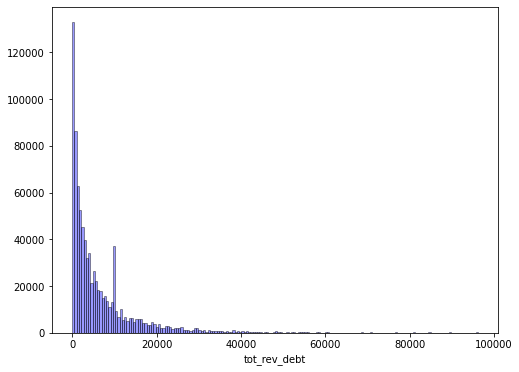

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(sample_df.tot_rev_debt[sample_df.tot_rev_debt > 0], hist=True, kde=False, 
             bins=int(180/1), color = 'blue',
             hist_kws={'edgecolor':'black'} , ax = ax )

In [ ]:
helper.fit_single_cont(sample_df.tot_rev_debt, sample_df.bad_ind, method = "chi_merge", min_samples = 0.02, max_bin = 5)

,bin,total,total_rate,bad,bad_rate,woe,iv
0,"(-990000, 4318.0]",540039,0.540039,111973,0.207342,1.341020,0.423887
1,"(4318.0, 9924.0]",180002,0.180002,30598,0.169987,1.585719,0.188393
2,"(9924.0, 9998.0]",29062,0.029062,9574,0.329434,0.710748,0.007046
3,"(9998.0, 25277.0]",130942,0.130942,20513,0.156657,1.683314,0.151357
4,"(25277.0, inf]",37437,0.037437,4445,0.118733,2.004485,0.057222
5,[nan],82218,0.082218,27629,0.336046,0.680966,0.018359
6,[-999999.0],300,0.0003,63,0.21,1.324925,0.000231


In [ ]:
c.fit(sample_df.tot_rev_debt, sample_df.bad_ind, method = 'chi', min_samples = 0.02, empty_separate = True)
c.export()

{'tot_rev_debt': [515.0, 9924.0, 10256.0, nan]}

## many missing value

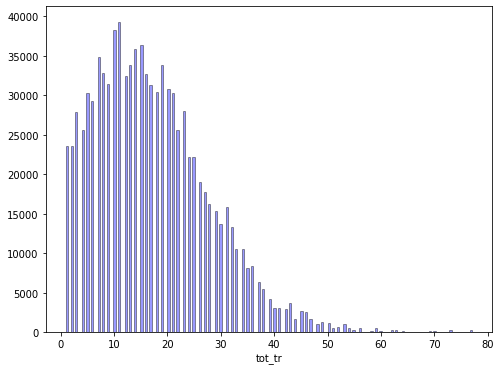

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(sample_df.tot_tr[sample_df.tot_tr> 0], hist=True, kde=False, 
             bins=int(180/1), color = 'blue',
             hist_kws={'edgecolor':'black'} , ax = ax )

In [ ]:
helper.fit_single_cont(sample_df.tot_tr, sample_df.bad_ind, method = "chi", min_samples = 0.02, max_bin = 5)

,bin,total,total_rate,bad,bad_rate,woe,iv
0,"(-990000.0, 6.0]",163267,0.163267,43383,0.265718,1.016457,0.077760
1,"(6.0, 10.0]",137320,0.13732,39113,0.284831,0.920623,0.054403
2,"(10.0, 11.0]",39276,0.039276,8194,0.208626,1.333227,0.030515
3,"(11.0, 13.0]",66264,0.066264,16052,0.242243,1.140421,0.038957
4,"(13.0, 14.0]",35855,0.035855,6829,0.190462,1.447014,0.032119
5,"(14.0, 16.0]",68991,0.068991,12635,0.18314,1.495218,0.065372
6,"(16.0, 30.0]",336431,0.336431,51741,0.153794,1.705150,0.397213
7,"(30.0, inf]",114419,0.114419,14512,0.126832,1.929264,0.164749
8,[nan],37179,0.037179,12129,0.326233,0.725275,0.009371
9,[-999999.0],99,9.9e-05,23,0.232323,1.195239,0.000063


In [ ]:
c.fit(sample_df.tot_tr, sample_df.bad_ind, method = 'chi', empty_separate = True, n_bins = 5)
print(c.export().get("tot_tr"))

[7.0, 8.0, 14.0, 24.0, nan]


## force_mono -- plot

In [ ]:
from toad.plot import bin_plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.


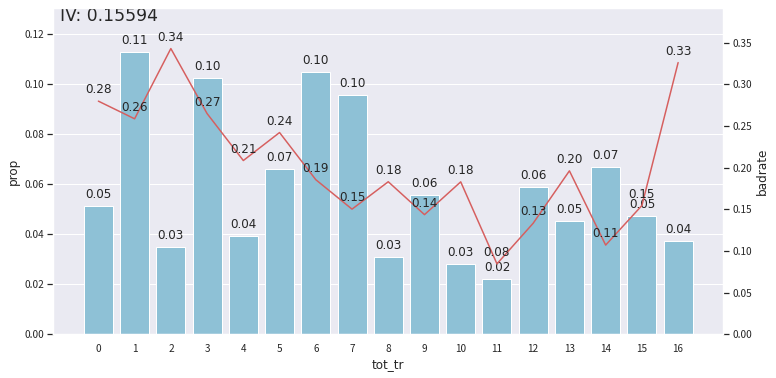

In [ ]:
# It's recommended to set 'labels = True' for better visualisation.
c.fit(sample_df.tot_tr, sample_df.bad_ind, method = 'chi', empty_separate = True, min_samples = 0.02, n_bins = 10)
bin_plot(c.transform(sample_df.copy(), labels=False), x="tot_tr", target='bad_ind')

In [ ]:
helper.fit(sample_df, sample_df.bad_ind, method = "chi", min_samples = 0.02, max_bin = 10, force_mono = None , feature_list = ["tot_tr"])

fitting:  tot_tr


In [ ]:
helper.woe_encoder

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 3.0]",78223,0.078223,21691,0.277297,0.957909,0.033375,tot_tr,False
1,"(3.0, 6.0]",85044,0.085044,21692,0.255068,1.071763,0.044650,tot_tr,False
2,"(6.0, 7.0]",34843,0.034843,11954,0.343082,0.649590,0.007103,tot_tr,False
3,"(7.0, 10.0]",102477,0.102477,27159,0.265025,1.020011,0.049123,tot_tr,False
4,"(10.0, 11.0]",39276,0.039276,8194,0.208626,1.333227,0.030515,tot_tr,False
5,"(11.0, 13.0]",66264,0.066264,16052,0.242243,1.140421,0.038957,tot_tr,False
6,"(13.0, 14.0]",35855,0.035855,6829,0.190462,1.447014,0.032119,tot_tr,False
7,"(14.0, 16.0]",68991,0.068991,12635,0.18314,1.495218,0.065372,tot_tr,False
8,"(16.0, 27.0]",291182,0.291182,42861,0.147197,1.756760,0.360944,tot_tr,False
9,"(27.0, 30.0]",45249,0.045249,8880,0.196247,1.409915,0.038757,tot_tr,False


transforming:  tot_tr


No handles with labels found to put in legend.
No handles with labels found to put in legend.


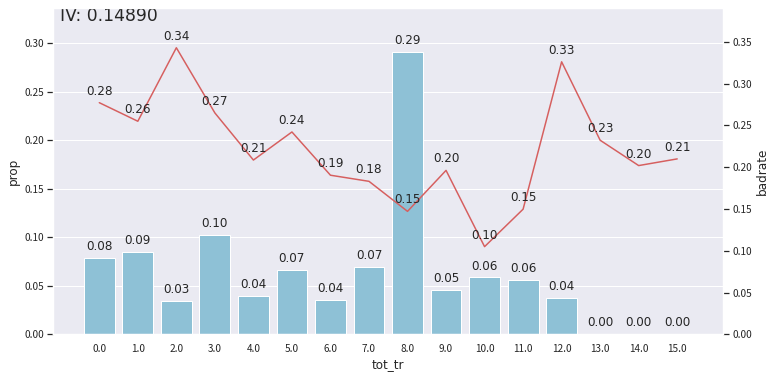

In [ ]:
bin_plot(helper.transform(sample_df, inplace = False, bin_only = None, feature_list = ["tot_tr"]), x="tot_tr", target='bad_ind')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


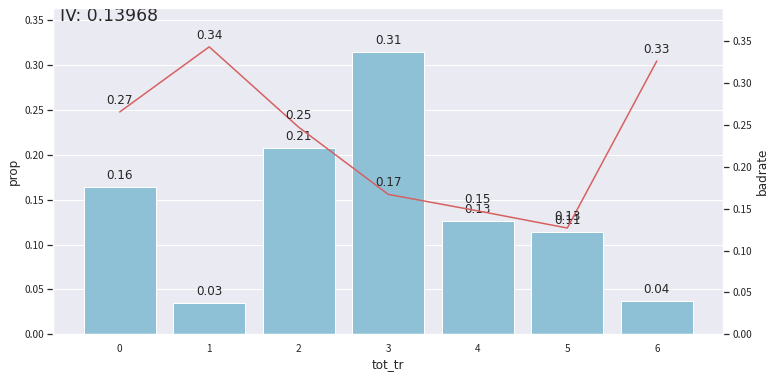

In [ ]:
## toad has NO automated way of forcing mono
## user has to adjust n_bins and fit() many times

c.fit(sample_df.tot_tr, sample_df.bad_ind, method = 'chi', empty_separate = True, n_bins = 6)
bin_plot(c.transform(sample_df.copy(), labels=False), x="tot_tr", target='bad_ind')

fitting:  tot_tr
transforming:  tot_tr


No handles with labels found to put in legend.
No handles with labels found to put in legend.


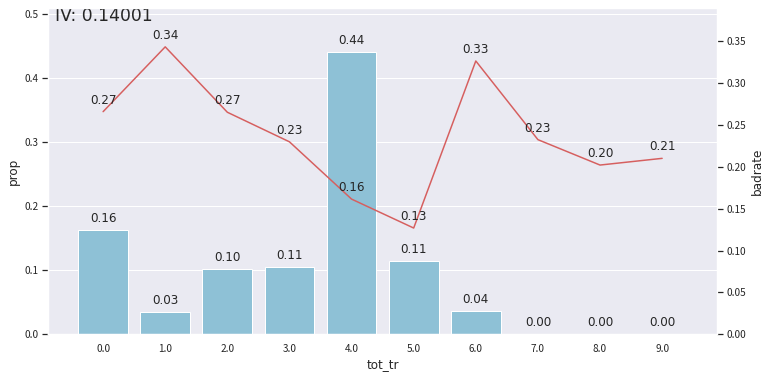

In [ ]:
helper = VarBinHelper()
helper.fit(sample_df, sample_df.bad_ind, method = "chi", min_samples = 0.005, max_bin = 10, force_mono = "u_shape", feature_list = ["tot_tr"])
bin_plot(helper.transform(sample_df, inplace = False, bin_only = None, feature_list = ["tot_tr"]), x="tot_tr", target='bad_ind')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


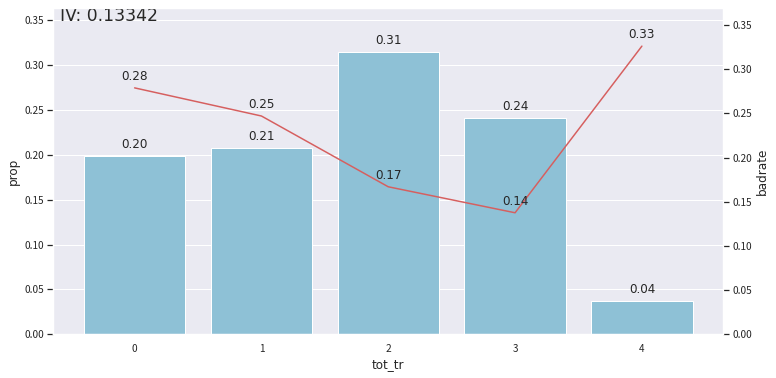

In [ ]:
## toad has NO automated way of forcing mono
## user has to adjust n_bins and fit() many times

c.fit(sample_df.tot_tr, sample_df.bad_ind, method = 'chi', empty_separate = True, n_bins = 4)
bin_plot(c.transform(sample_df.copy(), labels=False), x="tot_tr", target='bad_ind')

fitting:  tot_tr
transforming:  tot_tr


No handles with labels found to put in legend.
No handles with labels found to put in legend.


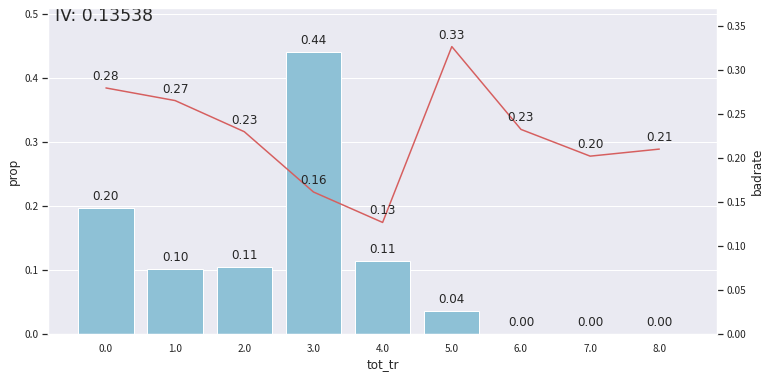

In [ ]:
helper = VarBinHelper()
helper.fit(sample_df, sample_df.bad_ind, method = "chi", min_samples = 0.005, max_bin = 10, force_mono = "mono", feature_list = ["tot_tr"])
bin_plot(helper.transform(sample_df, inplace = False, bin_only = None, feature_list = ["tot_tr"]), x="tot_tr", target='bad_ind')

## merging categorical values

In [ ]:
sample_df.vehicle_make.value_counts()

FORD         190156
CHEVY        111830
DODGE         91130
TOYOTA        71319
CHEVROLET     45319
              ...  
PORSHE          171
NISS            170
PARK            170
CHYRSLER        170
CHEVY\          170
Name: vehicle_make, Length: 155, dtype: int64

In [ ]:
c.fit(sample_df.vehicle_make, sample_df.bad_ind, method = 'chi', min_samples = 0.02, empty_separate = True)

In [ ]:
len(c.export().get("vehicle_make"))

4

In [ ]:
helper.fit_single_cat(sample_df.vehicle_make, sample_df.bad_ind, method = "chi_merge", min_samples = 0.02, max_bin = 6)

NA values  [None]  not found in  vehicle_make


,bin,total,total_rate,bad,bad_rate,woe,iv
0,"[PORSHE, MECURY, HYU., SKI DOO, DOGE, CHEV X-C...",20012,0.020012,0,0,32.132230,0.643030
1,"[LEXUS, AUDI, PORSCHE, VOLKSWAGEN, MITS, ACURA...",25140,0.02514,2052,0.0816229,2.420498,0.050918
2,"[MERCEDES, BMW, HONDA]",39666,0.039666,5302,0.133666,1.868925,0.054315
3,"[SATURN, LINCOLN, MITSU, OLDSMOBILE, CHRYSLER,...",883898,0.883898,184166,0.208357,1.334860,0.688208
4,[nan],499,0.000499,104,0.208417,1.334495,0.000388
5,"[ISUZU, SUZUKI, DAEWOO, MERC, PLY, SAAB, PLYM,...",17955,0.017955,5474,0.304873,0.824198,0.005775
6,"[MITSUBISHI, CHRY, CAD, HYNDAI, RAM, MITISBUSH...",12830,0.01283,7697,0.599922,-0.405140,0.001039


In [ ]:
helper.fit_single_cat(sample_df.vehicle_make, sample_df.bad_ind, method = "chi_merge", min_samples = 0.02, max_bin = 6, merge_category = False)

NA values  [None]  not found in  vehicle_make
vehicle_make is categorical, not merging bins according to user's input merge_category


,bin,total,total_rate,bad,bad_rate,woe,iv
0,[CHRYS],171,0.000171,0,0,27.369806,0.004680
1,[DODG],171,0.000171,0,0,27.369806,0.004680
2,[GMAC],171,0.000171,0,0,27.369806,0.004680
3,[JEEP CHEROKEE],171,0.000171,0,0,27.369806,0.004680
4,[RANGER],171,0.000171,0,0,27.369806,0.004680
...,...,...,...,...,...,...,...
151,[CHEYV],342,0.000342,342,1,-28.062954,0.009598
152,[CHEVY\],170,0.00017,170,1,-27.363941,0.004652
153,[CHYRLER],171,0.000171,171,1,-27.369806,0.004680
154,[MITS.],171,0.000171,171,1,-27.369806,0.004680


## user set rules

In [ ]:
dict_rule = {"tot_rev_debt":[0,2000,4000,6000,10000], 
             "vehicle_make":[['nan'],['FORD','LEXUS'],['B50'],['SUZUKI']],
             "tot_tr":[0,1,2,3,4,8,9,10] }

In [ ]:
helper_chi_u_shape = VarBinHelper()
helper_chi_u_shape.fit(sample_df.loc[0:10000], sample_df.loc[0:10000,"bad_ind"], method = "chi", force_mono = "u_shape", categorical_features = lst_cat)

------- fitting:  vehicle_year  -------
NA values  [None]  not found in  vehicle_year
vehicle_year has limited unique values, count < max_bin, skipped merging
------- fitting:  vehicle_make  -------
NA values  [None]  not found in  vehicle_make
------- fitting:  bankruptcy_ind  -------
NA values  [None]  not found in  bankruptcy_ind
bankruptcy_ind has limited unique values, count < max_bin, skipped merging
------- fitting:  used_ind  -------
NA values  ['nan', None]  not found in  used_ind
used_ind has limited unique values, count < max_bin, skipped merging
fitting:  weight
weight has limited unique values, count < max_bin, skipped merging / cutting
fitting:  account_number
account_number  rounded to decimal point:  -3    unique values counts =  4418
fitting:  msrp
fitting:  ltv
fitting:  veh_mileage
fitting:  tot_rev_tr
fitting:  purch_price
fitting:  tot_rev_line
fitting:  tot_tr
fitting:  tot_open_tr
fitting:  tot_rev_debt
fitting:  fico_score
fitting:  rev_util
fitting:  applicatio

In [ ]:
helper_chi_u_shape.fit_single_cat(sample_df.loc[:,"used_ind"].astype(str), sample_df.loc[0:10000,"bad_ind"], merge_category = False)

NA values  ['nan', None]  not found in  used_ind
used_ind has limited unique values, count < max_bin, skipped merging


,bin,total,total_rate,bad,bad_rate,woe,iv
0,[2],40000,0.04,0,0,32.824778,1.312991
1,[1],5674,0.005674,0,0,30.871792,0.175167
2,[0],954326,0.954326,2049,0.00214707,6.141504,5.835829


In [ ]:
sample_df.used_ind.value_counts()

0    954326
2     40000
1      5674
Name: used_ind, dtype: int64

In [ ]:
helper_chi_u_shape.missing_values_found

In [ ]:
dict_na

{'vehicle_make': ['FORD', 'B50'], 'vehicle_year': ['1998.0']}

In [ ]:
helper_chi_u_shape.transform(sample_df.loc[0:10000], inplace = False)

In [ ]:
helper_chi_u_shape.set_rules(dict_rules = dict_rule, data = sample_df)

updated bins for  tot_rev_debt  , the df is now like:
2                 bin   total total_rate    bad  ba...
Name: bin_info, dtype: object
user bin df is:
             bin   total total_rate    bad  bad_rate       woe        iv
0   (-990000, 0]   52658   0.052658   8720  0.165597  1.617160  0.056953
1      (0, 2000]  320019   0.320019  69061  0.215803  1.290295  0.234701
2   (2000, 4000]  146673   0.146673  29917  0.203971  1.361659  0.118245
3   (4000, 6000]   94201   0.094201  16413  0.174234  1.555913  0.095494
4  (6000, 10000]  135552   0.135552  28034  0.206814  1.344240  0.106846
5   (10000, inf]  168379   0.168379  24958  0.148225  1.748590  0.207143
6          [nan]   82218   0.082218  27629  0.336046  0.680966  0.018359
7    [-999999.0]     300     0.0003     63      0.21  1.324925  0.000231
updated bins for  vehicle_make  , the df is now like:
0                                                  ...
Name: bin_info, dtype: object
user bin df is:
                                 

In [ ]:
trans_df = helper_chi_u_shape.transform(sample_df, inplace = False, bin_only = True, feature_list = ["tot_tr"])

## tot_tr now following user's bin
trans_df.tot_tr.value_counts()

transforming:  tot_tr


(10, inf]       661236
(4, 8]          127064
(9, 10]          38252
(8, 9]           31431
(2, 3]           27840
(3, 4]           25617
(0, 1]           23570
(1, 2]           23569
(-990000, 0]      3244
-999902.0          599
-999901.0          300
-999999.0           99
Name: tot_tr, dtype: int64

In [ ]:
## to restore rules found by fit(), simply pass dict_rules = "recover"
helper_chi_u_shape.set_rules(dict_rules = "recover", data = None)

In [ ]:
trans_df = helper_chi_u_shape.transform(sample_df, inplace = False, bin_only = True, feature_list = ["tot_tr"])

trans_df.tot_tr.value_counts()
## tot_tr now following original bin

transforming:  tot_tr


(15.0, inf]         483464
(8.0, 13.0]         175223
(-990000.0, 6.0]    163267
(13.0, 15.0]         72232
(6.0, 8.0]           67637
-999902.0              599
-999901.0              300
-999999.0               99
Name: tot_tr, dtype: int64

In [ ]:
c.set_rules(dict_rule)

In [ ]:
c.export().get("tot_tr")

[0, 1, 2, 3, 4, 8, 9, 10]

## set decimal VS toad

In [ ]:
for col in sample_df.columns.to_list():
    print(col, sample_df[col].nunique())

In [ ]:
import random
for i in range(0, len(sample_df), 10000):
    sample_df.loc[i:i+10000, "loan_amt"] = sample_df.loc[i:i+10000, "loan_amt"]*(1+random.randrange(-500,500)/1000)


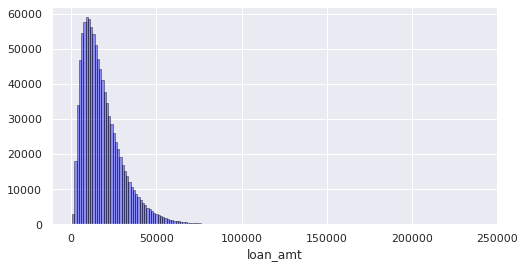

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(sample_df.loan_amt, hist=True, kde=False, 
             bins=int(180/1), color = 'blue',
             hist_kws={'edgecolor':'black'} , ax = ax )

In [ ]:
sample_df["loan_amt"].nunique()
sample_df["loan_amt"].nunique()

884316

In [ ]:
t0 = time()
helper_chi_u_shape.fit(sample_df.loc[:,["loan_amt"]], 
                       sample_df.bad_ind, method = "chi", force_mono = "u_shape", unique_range = (100000, 500000))
time()-t0

no categorical_features list is passed, assuming all features are numerical.
fitting:  loan_amt
loan_amt  rounded to decimal point:  1    unique values counts =  361576


2.3424031734466553

In [ ]:
t0 = time()
c.fit(sample_df.loc[:,["loan_amt"]], sample_df.bad_ind, method = "kmeans")
time()-t0

37.88894844055176

In [ ]:
c.export()

{'loan_amt': [3381.7677001953125,
  13600.87255859375,
  17232.51171875,
  21909.7294921875,
  21912.68359375,
  56526.736328125,
  56528.451171875,
  72508.8828125,
  144339.546875]}

In [ ]:
time()-t0

4145.899758815765

# set_rules() test

In [ ]:
model_copy = helper_iv_mono.model.copy()

In [ ]:
model_copy.bin_info[17]

,bin,total,total_rate,bad,bad_rate
0,[nan],1087,0.1087,264,0.24287
1,[-999902.0],599,0.0599,121,0.202003
2,[-999901.0],300,0.03,63,0.21
3,[-990001.0],99,0.0099,23,0.232323
4,"(-990000.0, 16.0]",4189,0.4189,1031,0.246121
5,"(16.0, 23.0]",1754,0.1754,271,0.154504
6,"(23.0, inf]",1972,0.1972,276,0.139959


In [ ]:
helper_iv_mono = VarBinHelper(label = 'bad_ind')
helper_iv_mono._fit = True
helper_iv_mono.model = model_copy

In [ ]:
helper_iv_mono.model

,feature_name,is_cat,bin_info
0,vehicle_year,True,...
1,vehicle_make,True,...
2,bankruptcy_ind,True,bin total total_rate bad bad_rate ...
3,tot_rev_debt,False,bin total total_rate ...
4,loan_amt,False,bin total total_rate ba...
5,purch_price,False,bin total total_rate ba...
6,rev_util,False,bin total total_rate bad ...
7,tot_open_tr,False,bin total total_rate bad ba...
8,age_oldest_tr,False,bin total total_rate ...
9,tot_derog,False,bin total total_rate bad bad...


In [ ]:
helper_iv_mono.model.bin_info[6]

,bin,total,total_rate,bad,bad_rate,woe,iv
0,[nan],0,0,0,NaN,NaN,NaN
1,"(-990000.0, 36.92]",5552,0.1629,862,0.155259,1.693933,0.029474
2,"(36.92, inf]",4448,0.4448,1187,0.266862,1.010605,0.416874


In [ ]:
df_small = sample_df[0:10000].copy()
helper_iv_mono.transform(df_small, inplace = True, bin_only = False)

,vehicle_year,vehicle_make,bankruptcy_ind,tot_rev_debt,loan_amt,purch_price,rev_util,tot_open_tr,age_oldest_tr,tot_derog,veh_mileage,tot_rev_tr,msrp,tot_rev_line,loan_term,fico_score,used_ind,tot_tr,down_pyt,ltv,tot_income
0,1.274767,1.223631,1.404706,1.324925,1.343527,1.205526,1.010605,1.448978,1.093004,0.854217,1.472367,1.445856,1.32172,0.991192,1.901458,0.788138,1.355946,1.324925,1.283462,1.244858,1.887965
1,1.540673,0.751416,1.404706,1.324925,1.343527,1.522733,1.010605,1.426414,2.201844,1.917251,1.472367,1.445856,1.32172,2.411910,1.298669,0.788138,1.355946,1.324925,1.283462,1.244858,1.275045
2,1.274767,1.429099,1.404706,1.324925,1.343527,1.205526,1.693933,1.101414,1.093004,0.854217,1.472367,0.674927,1.32172,0.668779,1.298669,0.788138,1.355946,1.324925,1.283462,1.244858,1.275045
3,1.331900,1.223631,1.404706,1.324925,1.343527,1.205526,1.010605,1.448978,1.093004,0.854217,1.472367,1.445856,1.32172,0.991192,1.298669,0.788138,1.355946,1.324925,1.505188,1.244858,1.275045
4,1.540673,1.429099,1.404706,1.324925,1.343527,1.522733,1.693933,1.448978,1.093004,1.917251,1.472367,1.632968,1.32172,0.991192,1.298669,2.889303,1.355946,1.324925,1.283462,1.244858,1.275045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.331900,1.429099,1.404706,1.362764,1.343527,1.522733,1.010605,1.426414,1.093004,0.854217,1.472367,1.445856,1.32172,0.991192,1.298669,0.788138,1.355946,1.119410,1.505188,1.244858,1.275045
9996,1.540673,1.429099,1.404706,1.362764,1.343527,1.522733,1.010605,1.101414,1.093004,1.253613,1.472367,1.445856,1.32172,0.991192,1.298669,0.788138,1.355946,1.119410,1.283462,2.202687,1.275045
9997,1.540673,1.429099,1.404706,1.362764,1.343527,1.522733,1.010605,1.448978,1.093004,1.917251,1.472367,1.445856,1.32172,0.991192,1.298669,2.889303,1.355946,1.119410,1.283462,1.244858,1.275045
9998,1.540673,-0.283575,1.404706,0.944946,1.343527,1.522733,1.693933,1.101414,1.093004,0.854217,1.472367,0.674927,1.32172,0.668779,1.298669,0.693147,1.355946,1.119410,1.283462,1.244858,1.275045


In [ ]:
df_small

,bad_ind,vehicle_year,vehicle_make,bankruptcy_ind,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,tot_rev_tr,tot_rev_debt,tot_rev_line,rev_util,fico_score,purch_price,msrp,down_pyt,loan_term,loan_amt,ltv,tot_income,veh_mileage,used_ind
0,1,1.274767,1.22363,1.40471,0.854217,1.324925,1.093004,1.448978,1.445856,1.324925,0.991192,1.010605,0.788138,1.205526,1.32172,1.283462,1.901458,1.343527,1.244858,1.887965,1.472367,1.355946
1,0,1.540673,0.751416,1.40471,1.917251,1.324925,2.201844,1.426414,1.445856,1.324925,2.411910,1.010605,0.788138,1.522733,1.32172,1.283462,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946
2,1,1.274767,1.4291,1.40471,0.854217,1.324925,1.093004,1.101414,0.674927,1.324925,0.668779,1.693933,0.788138,1.205526,1.32172,1.283462,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946
3,1,1.331900,1.22363,1.40471,0.854217,1.324925,1.093004,1.448978,1.445856,1.324925,0.991192,1.010605,0.788138,1.205526,1.32172,1.505188,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946
4,0,1.540673,1.4291,1.40471,1.917251,1.324925,1.093004,1.448978,1.632968,1.324925,0.991192,1.693933,2.889303,1.522733,1.32172,1.283462,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1.331900,1.4291,1.40471,0.854217,1.119410,1.093004,1.426414,1.445856,1.362764,0.991192,1.010605,0.788138,1.522733,1.32172,1.505188,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946
9996,0,1.540673,1.4291,1.40471,1.253613,1.119410,1.093004,1.101414,1.445856,1.362764,0.991192,1.010605,0.788138,1.522733,1.32172,1.283462,1.298669,1.343527,2.202687,1.275045,1.472367,1.355946
9997,0,1.540673,1.4291,1.40471,1.917251,1.119410,1.093004,1.448978,1.445856,1.362764,0.991192,1.010605,2.889303,1.522733,1.32172,1.283462,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946
9998,1,1.540673,-0.283575,1.40471,0.854217,1.119410,1.093004,1.101414,0.674927,0.944946,0.668779,1.693933,0.693147,1.522733,1.32172,1.283462,1.298669,1.343527,1.244858,1.275045,1.472367,1.355946


In [ ]:
helper_iv_mono.model.bin_info[3]['woe'] = 0
helper_iv_mono.model.bin_info[3]

,bin,total,total_rate,bad,bad_rate,woe
0,[nan],1229,0.1229,344,0.279902,0
1,[-999999.0],300,0.03,63,0.21,0
2,"(-990000.0, 10164.71141]",6963,0.6963,1419,0.203791,0
3,"(10164.71141, inf]",1508,0.0085,223,0.147878,0


In [ ]:
helper_iv_mono.model.bin_info[3]

In [ ]:
df_risk_trend = helper_iv_mono.model.bin_info[3]
df_risk_trend['good'] = df_risk_trend['total'] - df_risk_trend['bad']
df_risk_trend['good_density'] = df_risk_trend['total_rate'] * (1 - df_risk_trend['bad_rate'])
df_risk_trend['bad_density'] = df_risk_trend['total_rate'] * df_risk_trend['bad_rate']
df_risk_trend['good_over_bad'] = df_risk_trend['good_density'] / df_risk_trend['bad_density']
df_risk_trend['woe_handmade'] = np.log((df_risk_trend['good_density'].astype('float64')) / (df_risk_trend['bad_density'].astype('float64')))
df_risk_trend['iv'] = np.log((df_risk_trend['good_density'].astype('float64')) / (df_risk_trend['bad_density'].astype('float64'))) * (df_risk_trend['good_density'].astype('float64') - df_risk_trend['bad_density'].astype('float64'))

In [ ]:
df_risk_trend

,bin,total,total_rate,bad,bad_rate,woe,good,good_density,bad_density,good_over_bad,woe_handmade,iv
0,[nan],1229,0.1229,344,0.279902,0,885,0.0885,0.0344,2.57267,0.944946,0.051122
1,[-999999.0],300,0.03,63,0.21,0,237,0.0237,0.0063,3.7619,1.324925,0.023054
2,"(-990000.0, 10164.71141]",6963,0.6963,1419,0.203791,0,5544,0.5544,0.1419,3.90698,1.362764,0.562140
3,"(10164.71141, inf]",1508,0.0085,223,0.147878,0,1285,0.00724304,0.00125696,5.76233,1.751342,0.010484


In [ ]:
helper_iv_mono.model.bin_info[1]

,bin,total,total_rate,bad,bad_rate
0,[nan],NaN,NaN,NaN,NaN
1,"[FORD, LEXUS]",NaN,NaN,NaN,NaN
2,[B50],NaN,NaN,NaN,NaN
3,[SUZUKI],NaN,NaN,NaN,NaN
4,"[GMC, CADI, VOLKSWAGEN, HUUNDAI, MITSUBISHI, S...",NaN,NaN,NaN,NaN


In [ ]:
for key in dict_rule:
    print(key in model_copy.feature_name.to_list())

True


In [ ]:
dict_rule = {"tot_rev_debt":[0,2000,4000,6000,10000], 
             "vehicle_make":[['nan'],['FORD','LEXUS'],['B50'],['SUZUKI']],
             "tot_tr":[[-999901,-999902],[-990001],[np.nan],0,3,5,9,12,15]
             }

In [ ]:
helper_iv_mono.set_rules(dict_rule)

updated bins for  tot_rev_debt  , the df is now like:
3                 bin total total_rate  bad bad_rat...
Name: bin_info, dtype: object
user bin df is:
             bin total total_rate  bad bad_rate
0          [nan]   NaN        NaN  NaN      NaN
1    [-999999.0]   NaN        NaN  NaN      NaN
2   (-990000, 0]   NaN        NaN  NaN      NaN
3      (0, 2000]   NaN        NaN  NaN      NaN
4   (2000, 4000]   NaN        NaN  NaN      NaN
5   (4000, 6000]   NaN        NaN  NaN      NaN
6  (6000, 10000]   NaN        NaN  NaN      NaN
7   (10000, inf]   NaN        NaN  NaN      NaN
updated bins for  vehicle_make  , the df is now like:
1                                                  ...
Name: bin_info, dtype: object
user bin df is:
                                                 bin total  ...  bad bad_rate
0                                              [nan]   NaN  ...  NaN      NaN
1                                      [FORD, LEXUS]   NaN  ...  NaN      NaN
2                       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1008: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1008: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1008: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Draft

In [ ]:
print("helllo")

helllo


In [ ]:
d = {"col1":[0,3,5,7,9], "col2":[['nan'],["FORD","B50"],["VOLVO"]]}

In [ ]:
for key in d:
    print(d.get(key))

[0, 3, 5, 7, 9]
[['nan'], ['FORD', 'B50'], ['VOLVO']]


In [ ]:
import pandas as pd
import numpy as np
df = pd.DataFrame([[[1],np.nan,3],[[3],4,5],[5,True,7],[5.888888,6,7],[np.inf,6,7],[-999900,6,7]], columns = ['a','b','c'])

In [ ]:
dic = {}
if dic:
    print(True)

In [ ]:
df.loc[df.a == 5].b.iloc[0]

True

In [ ]:
lst = [9,8,12,13,15,-990000,np.inf,10]
lst.sort()
lst

[-990000, 8, 9, 10, 12, 13, 15, inf]

In [ ]:
float("nan") is float("nan")

False

In [ ]:
df.a.astype(str).str.isdigit()

0    False
1    False
2     True
3    False
4    False
5    False
Name: a, dtype: bool

In [ ]:
df['a'].loc[(df['a'].map(type) != list)].tolist()

[5, 5.888888, inf, -999900]

In [ ]:
lst = [[-999900],[-999901, -999902],3,4,5,6,7]

In [ ]:
sr_lst = pd.Series(lst)
sr_lst.map(type) == list

0     True
1     True
2    False
3    False
4    False
5    False
6    False
dtype: bool

In [ ]:
4 in sr_lst

True

In [ ]:
sr_lst[sr_lst.map(type) == list].to_list()

[[-999900], [-999901, -999902]]

In [ ]:
lst[:-1]

[[-999900], [-999901, -999902], 3, 4, 5, 6]

In [ ]:
np.nan is None

False

In [ ]:
a = None
a == False

False

In [ ]:
a = 1
def inc(n):
    n += n+1
inc(a)
a

1

In [ ]:
def f(nf, xf):
    nf = 2
    xf.append(4)
    print('In f():', nf, xf)

def main():
    nmain = 1
    xmain = [0,1,2,3]
    print('Before:', nmain, xmain)
    f(nmain, xmain)
    print('After: ', nmain, xmain)

main()

Before: 1 [0, 1, 2, 3]
In f(): 2 [0, 1, 2, 3, 4]
After:  1 [0, 1, 2, 3, 4]


In [ ]:
type(lst) == list

True

In [ ]:
a = True
a==1

True

In [ ]:
b = False
b == 0

True

In [ ]:
np.finfo(float).eps

2.220446049250313e-16

In [ ]:
np.nan is np.nan

True

In [ ]:
a = float("nan") 
a is np.nan

False

In [ ]:
np.nan in [np.nan]

True

In [ ]:
float("nan") in [np.nan]

False

In [ ]:
np.nan == "nan"

False

In [ ]:
np.nan is None

False

In [ ]:
l1 = [0,1,2,3,4,5]
l2 = [3,4,5]

# in l1 not in l2, in l2 not in l1
set(l1)-set(l2), set(l2)-set(l1), set(l1) != set(l2)

({0, 1, 2}, set(), True)

In [ ]:
l1 = [3,4,5]
l2 = [3,4,5]
set(l1) == set(l2)

True

# Debug init

In [ ]:
helper.force_monotone(helper.model.bin_info[12].iloc[0:8], force_mono = "mono")

,bin,total,total_rate,bad,bad_rate,woe,iv,var,is_cat
0,"(-990000.0, 8.0]",1881,0.1325,526,0.279638,1.032284,0.064931,tot_tr,False
1,"(8.0, 13.0]",1458,0.1458,351,0.240741,1.148623,0.086836,tot_tr,False
2,"(13.0, 30.0]",3648,0.0584,583,0.159814,1.460727,0.053170,tot_tr,False
3,"(30.0, 36.0]",531,0.0531,53,0.0998117,2.199319,0.093471,tot_tr,False


In [ ]:
## chi, 1_turn
helper_chi_u_shape = VarBinHelper(label='bad_ind')

helper_chi_u_shape.init_cont(sample_df.tot_rev_debt, sample_df.bad_ind,  method = "chi", init_method = "step", missing_values = NA_dict, force_mono = 'u_shape', unique_range = (1000,5000))


(           bin total total_rate  bad  bad_rate
 0        [nan]  1229     0.1229  344  0.279902
 1  [-999999.0]   300       0.03   63      0.21,
                         bin   bin_low   bin_up total total_rate bad  bad_rate
 bin_num                                                                      
 0            (-990000, 0.0] -990000.0      0.0   491     0.0491  79  0.160896
 1               (0.0, 39.0]       0.0     39.0   114     0.0114  23  0.201754
 2             (39.0, 105.0]      39.0    105.0   197     0.0197  34  0.172589
 3            (105.0, 187.0]     105.0    187.0   200       0.02  49     0.245
 4            (187.0, 279.0]     187.0    279.0   200       0.02  37     0.185
 5            (279.0, 380.0]     279.0    380.0   201     0.0201  43   0.21393
 6            (380.0, 473.0]     380.0    473.0   199     0.0199  37   0.18593
 7            (473.0, 566.0]     473.0    566.0   202     0.0202  59  0.292079
 8            (566.0, 692.0]     566.0    692.0   200       0.02 

In [ ]:
lst_na_lst

[[nan], [-999999.0]]

In [ ]:
sr_feature_sorted.iloc[199]

0.0

In [ ]:
helper_chi_u_shape = VarBinHelper(label='bad_ind')
helper_chi_u_shape.choose_turning_point_and_neighbor([0.4,0,0.1,0])

(1, 2)